In [2]:
import pandas as pd
import re
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe
from oauth2client.service_account import ServiceAccountCredentials

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from Contacts import contacts_df
import matplotlib.pyplot as plt
import seaborn as sns
#from Calls import calls_df

In [4]:
# Загрузка данных из Excel файла
file_path = 'update_deals.xlsx'
deals_df = pd.read_excel(file_path)

# Просмотр первых 5 строк данных
print(deals_df.head())

# Загрузка данных из Excel файла
file_path = 'update_spend.xlsx'
spend_df = pd.read_excel(file_path)

# Просмотр первых 5 строк данных
print(deals_df.head())

                    Id Deal Owner Name        Closing Date            Quality  \
0  5805028000056864768        Ben Hall 2024-06-20 23:45:36            C - Low   
1  5805028000056859648   Ulysses Adams 2024-06-21 00:00:00  E - Non Qualified   
2  5805028000056832000   Ulysses Adams 2024-06-21 00:00:00     D - Non Target   
3  5805028000056823808        Eva Kent 2024-06-21 00:00:00  E - Non Qualified   
4  5805028000056872960        Ben Hall 2024-06-21 00:00:00     D - Non Target   

      Stage                  Lost Reason       Page  \
0  New Lead               Invalid number  /eng/test   
1  New Lead  Conditions are not suitable    /at-eng   
2      Lost                   Non target    /at-eng   
3      Lost               Invalid number       /eng   
4      Lost                   Non target       /eng   

                            Campaign       SLA                  Ad  ...  \
0                      03.07.23women       NaN                 v16  ...   
1  performancemax_digitalmarkt_r

In [5]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21502 entries, 0 to 21501
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  21502 non-null  int64         
 1   Deal Owner Name     21502 non-null  object        
 2   Closing Date        21502 non-null  datetime64[ns]
 3   Quality             21502 non-null  object        
 4   Stage               21502 non-null  object        
 5   Lost Reason         21502 non-null  object        
 6   Page                21502 non-null  object        
 7   Campaign            21502 non-null  object        
 8   SLA                 15463 non-null  object        
 9   Ad                  14119 non-null  object        
 10  AdGroup             12426 non-null  object        
 11  Source              21502 non-null  object        
 12  Payment Type        21502 non-null  object        
 13  Product             21502 non-null  object    

In [6]:
spend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20779 entries, 0 to 20778
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         20779 non-null  datetime64[ns]
 1   Source       20779 non-null  object        
 2   Campaign     20779 non-null  object        
 3   Impressions  20779 non-null  int64         
 4   Spend        20779 non-null  float64       
 5   Clicks       20779 non-null  int64         
 6   AdGroup      13951 non-null  object        
 7   Ad           13951 non-null  object        
 8   Z_score      20779 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 1.4+ MB


In [ ]:
Шаги для расчета юнит-экономики по продуктам:
Сбор данных:

Доходы на продукт: Необходимо получить данные о доходах, которые приносит каждый продукт. Эти данные могут включать цену 
продукта и количество проданных единиц.

Затраты на продукт: Включают в себя себестоимость продукции (COGS), расходы на маркетинг, транспортировку, поддержку клиентов и т. д.

Расчет ключевых метрик:

Revenue per Unit (Выручка на единицу): Общий доход, полученный от продукта, деленный на количество проданных единиц.
Cost per Unit (Затраты на единицу): Общие затраты, связанные с продуктом, деленные на количество проданных единиц.
Contribution Margin (Маржинальный доход): Разница между выручкой на единицу и затратами на единицу.
Customer Acquisition Cost (CAC) на продукт: Расходы на привлечение клиентов, рассчитанные на единицу продукта.
Lifetime Value (LTV) на продукт: Прогнозируемая сумма прибыли, которую принесет клиент на протяжении всего срока взаимодействия с продуктом.
Анализ прибыльности:

Сравнение маржинального дохода с затратами на привлечение клиентов (CAC). Это покажет, насколько продукт прибыльный и стоит ли 
продолжать его продажу или необходимо оптимизировать расходы.
Выводы и рекомендации:

Продукты с положительной юнит-экономикой и высоким маржинальным доходом должны быть в фокусе для увеличения продаж и дальнейшего маркетинга.
Продукты с низкой или отрицательной юнит-экономикой требуют пересмотра стратегии, возможного увеличения цены или снижения затрат.

In [ ]:
Агрегация данных:

Подсчет общего дохода и количества сделок для каждого продукта.
Подсчет затрат на маркетинг для каждого продукта на основе кампаний и источников.
Расчет ключевых метрик юнит-экономики:

Выручка на единицу продукта (Revenue per Unit).
Затраты на единицу продукта (Cost per Unit).
Маржинальный доход (Contribution Margin).
Стоимость привлечения клиента (CAC).
Соотношение LTV/CAC.
Анализ и выводы:

Определение прибыльности каждого продукта и предоставление рекомендаций по оптимизации.

In [7]:
# Приведение названий столбцов к нижнему регистру для унификации
deals_df.columns = deals_df.columns.str.lower()
spend_df.columns = spend_df.columns.str.lower()

# Фильтрация данных для включения только оплаченных сделок
paid_deals_df = deals_df[deals_df['stage'] == 'Payment Done']

# Группировка по продуктам для подсчета общего дохода и количества оплаченных сделок
product_summary = paid_deals_df.groupby('product').agg(
    total_revenue=('offer total amount', 'sum'),
    total_units_sold=('id', 'count')
).reset_index()

# 2. Агрегация данных из spend_df (группировка по кампаниям)
grouped_spend = spend_df.groupby('campaign').agg(
    total_spend=('spend', 'sum'),
    total_clicks=('clicks', 'sum'),
    total_impressions=('impressions', 'sum')
).reset_index()

# Соединение paid_deals_df и grouped_spend по Campaign
merged_df = pd.merge(paid_deals_df, grouped_spend, on='campaign', how='left')

# Добавление столбца с флагом, который указывает на первое вхождение каждой кампании
merged_df['first_occurrence'] = merged_df.duplicated(subset=['campaign'], keep='first')

# Оставляем клики, показы и расходы только для первого вхождения каждой кампании, остальные значения заполняем NaN
merged_df.loc[merged_df['first_occurrence'] == True, ['total_spend', 'total_clicks', 'total_impressions']] = np.nan

# Удаление вспомогательного столбца, так как он больше не нужен
merged_df.drop(columns=['first_occurrence'], inplace=True)

# Группировка по продуктам для подсчета общих затрат на маркетинг
product_spend = merged_df.groupby('product').agg(
    total_spend=('total_spend', 'sum'),
    total_clicks=('total_clicks', 'sum'),
    total_impressions=('total_impressions', 'sum')
).reset_index()

# 3. Объединение данных
product_economics = pd.merge(product_summary, product_spend, on='product', how='left')

# 4. Расчет ключевых метрик юнит-экономики

# Выручка на единицу
product_economics['revenue_per_unit'] = product_economics['total_revenue'] / product_economics['total_units_sold']

# Затраты на единицу
product_economics['cost_per_unit'] = product_economics['total_spend'] / product_economics['total_units_sold']

# Маржинальный доход на единицу
product_economics['contribution_margin'] = product_economics['revenue_per_unit'] - product_economics['cost_per_unit']

# Стоимость привлечения клиента (CAC) на единицу
product_economics['cac_per_unit'] = product_economics['total_spend'] / product_economics['total_units_sold']

# Соотношение LTV/CAC
product_economics['ltv_cac_ratio'] = product_economics['contribution_margin'] / product_economics['cac_per_unit']

# 5. Вывод результатов
print("Результаты агрегирования и расчетов:")
display(product_economics)

Результаты агрегирования и расчетов:


,product,total_revenue,total_units_sold,total_spend,total_clicks,total_impressions,revenue_per_unit,cost_per_unit,contribution_margin,cac_per_unit,ltv_cac_ratio
0,Digital Marketing,3944300.0,475,80924.80,266580.0,27625558.0,8303.789474,170.368000,8133.421474,170.368000,47.740312
1,Find yourself in IT,1.0,1,0.00,0.0,0.0,1.000000,0.000000,1.000000,0.000000,inf
2,UX/UI Design,1911400.0,236,42824.90,166637.0,20251786.0,8099.152542,181.461441,7917.691102,181.461441,43.632912
3,Web Developer,578100.0,136,19573.56,44657.0,1448329.0,4250.735294,143.923235,4106.812059,143.923235,28.534740


### Общий вывод на основании данной таблицы:
Продукты *"Digital Marketing"* и *"UX/UI Design"* демонстрируют наибольшую рентабельность, с высоким соотношением LTV/CAC, 

что указывает на эффективные инвестиции в маркетинг.
*"Web Developer"* также показывает хорошие результаты, хотя его соотношение LTV/CAC немного ниже.
*"Find yourself in IT"* имеет крайне низкие показатели, что может свидетельствовать о недостаточной рекламе или неудачной маркетинговой стратегии.
Поскольку, расчет производился по сделкам, которые имеют статус Payment Done, в наш расет не попал курс *"Data Analytics"*

### Анализ  юнит-экономики по продуктам:
**Анализ**:
Продукт *"Digital Marketing"* демонстрирует высокую выручку и хороший маржинальный доход на единицу товара. Соотношение LTV/CAC также высокое, что говорит о высокой рентабельности маркетинговых расходов. Это показывает, что маркетинговые усилия для этого продукта очень эффективны.

Продукт *"Find yourself in IT"* продал только одну единицу и не понес затрат на рекламу, что делает его соотношение LTV/CAC бесконечным. Это может указывать на то, что продукт не был активно рекламируем или недостаточно востребован.

Продукт *"UX/UI Design"* показывает хорошие результаты с точки зрения маржинального дохода и соотношения LTV/CAC. Этот продукт также является высоко рентабельным и генерирует значительную выручку.

Продукт *"Web Developer"* показывает умеренные результаты по сравнению с другими продуктами. Несмотря на более низкое соотношение LTV/CAC по сравнению с другими продуктами, он все еще является прибыльным, но, возможно, требует оптимизации маркетинговых расходов или увеличения продаж для повышения рентабельности.

**Заключение**:
*Digital Marketing* и *UX/UI Design* являются самыми рентабельными продуктами, с высокими показателями выручки и маржинального дохода.
Продукт *"Find yourself in IT"* нуждается в дополнительном внимании и, возможно, в пересмотре маркетинговой стратегии.
Продукт *"Web Developer"* имеет потенциал для роста, но требует оптимизации расходов или увеличения объема продаж для улучшения показателей юнит-экономики.

In [ ]:
Для расчета конверсии, переходящей от показов к оплаченной сделке, можно последовательно рассчитать несколько ключевых коэффициентов. 
Это позволит понять, на каком этапе воронки происходит наибольшее снижение конверсии и где возможны улучшения. Вот основные этапы и метрики, 
которые можно использовать:

Этапы воронки и расчет конверсии:
CTR (Click-Through Rate) — Кликабельность:

Формула: CTR = (Клики / Показов) * 100
Описание: Процент людей, которые кликнули на объявление, от общего числа тех, кто его увидел.
CR (Conversion Rate) — Конверсия кликов в созданные сделки:

Формула: CR = (Созданные сделки / Кликов) * 100
Описание: Процент людей, которые совершили целевое действие (например, оставили заявку или зарегистрировались), от числа тех, 
кто кликнул на объявление.
Lead-to-Sale Conversion Rate — Конверсия созданных сделок в оплаченные сделки:

Формула: Lead-to-Sale Conversion Rate = (Оплаченные сделки / Созданные сделки) * 100
Описание: Процент людей, которые завершили сделку (оплатили), от числа тех, кто создал сделку (например, оставил заявку).
Final Conversion Rate — Общая конверсия от показов до оплаченной сделки:

Формула: Final Conversion Rate = (Оплаченные сделки / Показов) * 100
Описание: Процент людей, которые увидели объявление и в конечном итоге совершили оплату.

In [8]:
#Этапы воронки и расчет конверсии:

# Соединение всех сделок с расходами на рекламу по кампаниям
merged_df = pd.merge(deals_df, grouped_spend, on='campaign', how='left')

# Добавление столбца с флагом, который указывает на первое вхождение каждой кампании
merged_df['first_occurrence'] = merged_df.duplicated(subset=['campaign'], keep='first')

# Оставляем клики, показы и расходы только для первого вхождения каждой кампании, остальные значения заполняем NaN
merged_df.loc[merged_df['first_occurrence'] == True, ['total_spend', 'total_clicks', 'total_impressions']] = np.nan

# Удаление вспомогательного столбца, так как он больше не нужен
merged_df.drop(columns=['first_occurrence'], inplace=True)

# Группировка данных по кампаниям для расчета основных метрик
campaign_summary = merged_df.groupby('campaign').agg(
    total_impressions=('total_impressions', 'sum'),
    total_clicks=('total_clicks', 'sum'),
    total_spend=('total_spend', 'sum'),
    total_deals=('id', 'count'),  # Общее количество созданных сделок
    payment_done_deals=('stage', lambda x: (x == 'Payment Done').sum())  # Количество оплаченных сделок
).reset_index()

# Расчет конверсий на каждом этапе воронки
campaign_summary['ctr %'] = (campaign_summary['total_clicks'] / campaign_summary['total_impressions']) * 100  # Конверсия от показов к кликам (CTR)
campaign_summary['deal_conversion_rate %'] = (campaign_summary['total_deals'] / campaign_summary['total_clicks']) * 100  # Конверсия от кликов к сделкам
campaign_summary['payment_conversion_rate %'] = (campaign_summary['payment_done_deals'] / campaign_summary['total_deals']) * 100  # Конверсия от сделок к оплате

# Вывод результата
display(campaign_summary[['campaign', 'total_impressions', 'total_clicks', 'total_deals', 'payment_done_deals', 'ctr %', 'deal_conversion_rate %', 'payment_conversion_rate %']])


,campaign,total_impressions,total_clicks,total_deals,payment_done_deals,ctr %,deal_conversion_rate %,payment_conversion_rate %
0,01.04.23women_PL,53650.0,635.0,43,1,1.183597,6.771654,2.325581
1,02.05.24test_DE,21365.0,848.0,162,4,3.969108,19.103774,2.469136
2,02.07.23wide_DE,775166.0,25558.0,1306,64,3.297100,5.109946,4.900459
3,02.08.23interests_DE,6827.0,370.0,11,0,5.419657,2.972973,0.000000
4,03.07.23women,495999.0,17370.0,789,42,3.502023,4.542314,5.323194
...,...,...,...,...,...,...,...,...
147,work_wr,0.0,0.0,8,0,NaN,inf,0.000000
148,workingin_DE,0.0,0.0,67,2,NaN,inf,2.985075
149,yo_DE,0.0,0.0,14,0,NaN,inf,0.000000
150,youtube_shorts_DE,8557218.0,64686.0,2205,84,0.755923,3.408775,3.809524


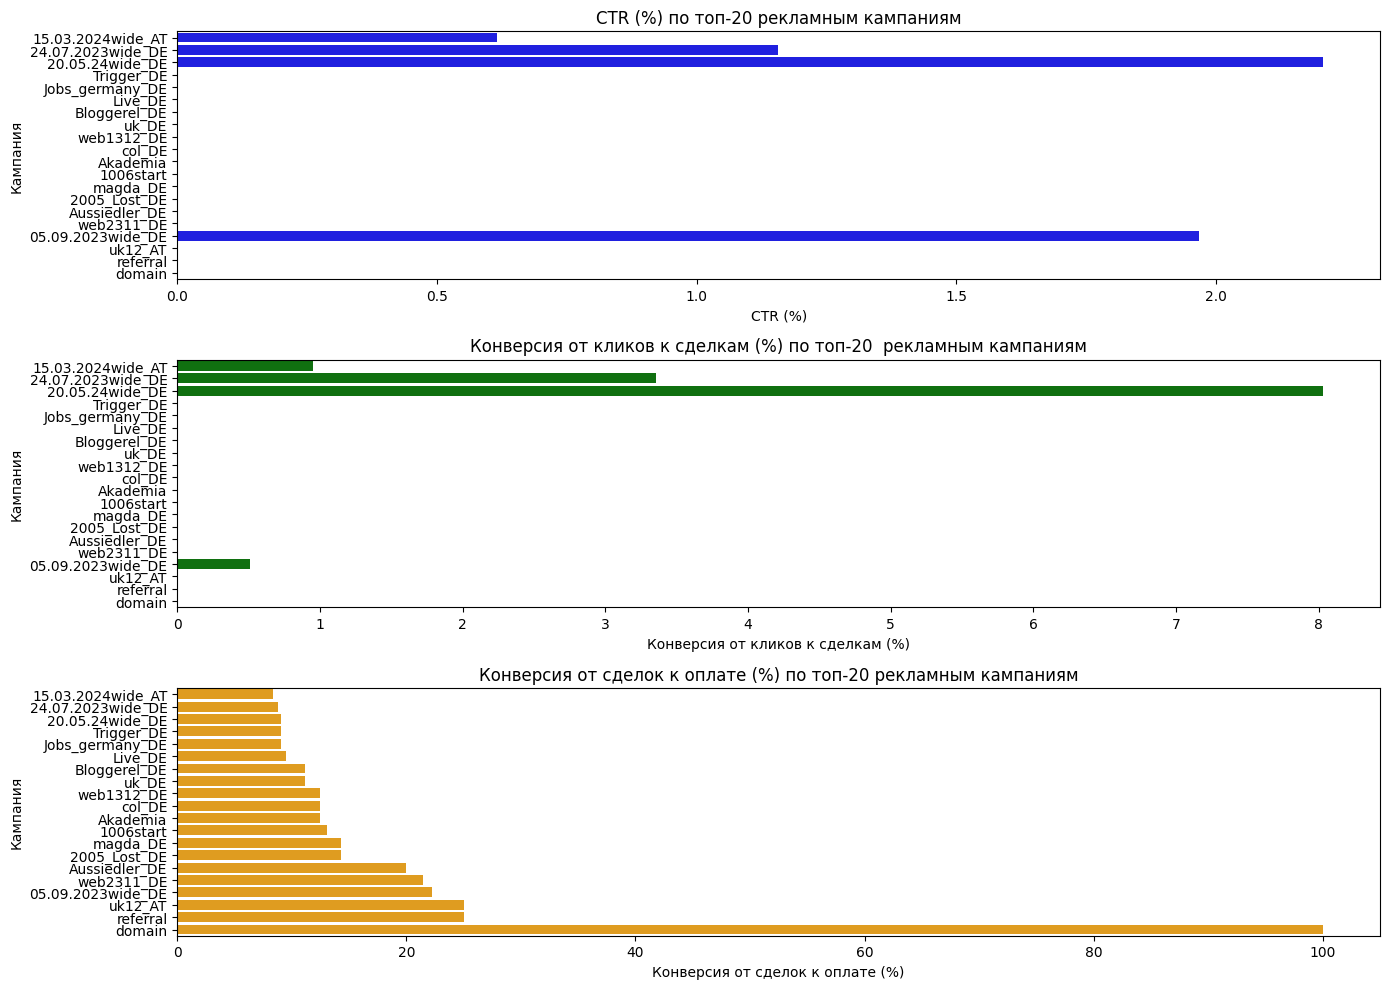

In [9]:
# Сортировка кампаний по конверсии от сделок к оплате и выбор топ-20
top_campaigns = campaign_summary.sort_values(by='payment_conversion_rate %', ascending=True).tail(20)

# Настройка размера фигуры с учетом меньшего количества кампаний
plt.figure(figsize=(14, 10))

# Создание диаграммы для CTR (конверсии от показов к кликам)
plt.subplot(3, 1, 1)
sns.barplot(x='ctr %', y='campaign', data= top_campaigns, color='blue')
plt.title('CTR (%) по топ-20 рекламным кампаниям')
plt.xlabel('CTR (%)')
plt.ylabel('Кампания')
plt.yticks(rotation=0, ha="right")  # Оставляем кампании горизонтально

# Создание диаграммы для конверсии от кликов к сделкам
plt.subplot(3, 1, 2)
sns.barplot(x='deal_conversion_rate %', y='campaign', data=top_campaigns, color='green')
plt.title('Конверсия от кликов к сделкам (%) по топ-20  рекламным кампаниям')
plt.xlabel('Конверсия от кликов к сделкам (%)')
plt.ylabel('Кампания')
plt.yticks(rotation=0, ha="right")  # Оставляем кампании горизонтально

# Создание диаграммы для конверсии от сделок к оплате
plt.subplot(3, 1, 3)
sns.barplot(x='payment_conversion_rate %', y='campaign', data=top_campaigns, color='orange')
plt.title('Конверсия от сделок к оплате (%) по топ-20 рекламным кампаниям')
plt.xlabel('Конверсия от сделок к оплате (%)')
plt.ylabel('Кампания')
plt.yticks(rotation=0, ha="right")  # Оставляем кампании горизонтально

# Показ диаграмм
plt.tight_layout()
plt.show()

### Анализ представленных графиков позволяет сделать несколько выводов о поведении рекламных кампаний на разных этапах воронки:

**CTR (Click-Through Rate, Конверсия от показов к кликам)**:
На первом графике видно, что большинство кампаний имеют очень низкий CTR, что может указывать на недостаточную привлекательность рекламных материалов или неправильную таргетированность аудитории. Только несколько кампаний показывают CTR выше 1-2%.

**Конверсия от кликов к сделкам**:
На втором графике видно, что некоторые кампании показывают хорошие результаты в преобразовании кликов в сделки, достигая конверсии выше 7%. Однако большинство кампаний имеют конверсию ниже 1%, что может указывать на проблемы с привлечением качественных лидов или неэффективность страницы посадки (landing page).

**Конверсия от сделок к оплате**:
На третьем графике видно, что конверсия от сделок к оплате значительно варьируется между кампаниями. Некоторые кампании имеют почти 100% конверсию, что означает, что практически каждая сделка, созданная в рамках этих кампаний, завершалась оплатой. В то же время, есть кампании с значительно более низкой конверсией, что может свидетельствовать о проблемах на этапе завершения сделки (например, неудачные условия оплаты или слабая работа отдела продаж).

**Выводы**:
**Необходимость оптимизации CTR**: Кампании с низким CTR требуют пересмотра рекламных материалов и стратегий таргетинга.
Оптимизация страницы посадки и процесса создания сделок: Кампании с низкой конверсией от кликов к сделкам могут требовать улучшения качества страниц посадки или уточнения целевой аудитории.
**Поддержка высокой конверсии от сделок к оплате**: Следует изучить успешные кампании с высокой конверсией от сделок к оплате для распространения их практик на менее успешные кампании.

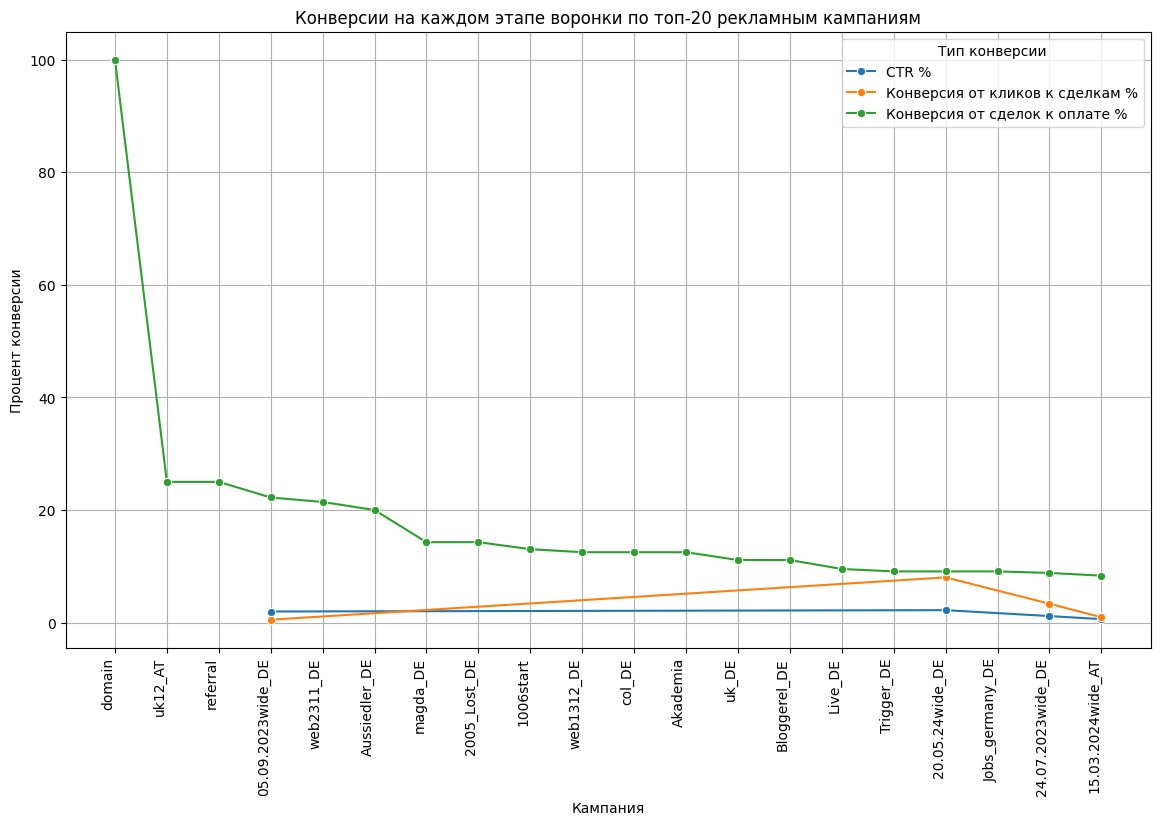

In [10]:
# Сортировка кампаний по конверсии от сделок к оплате и выбор топ-20
top_campaigns = campaign_summary.sort_values(by='payment_conversion_rate %', ascending=False).head(20)

# Настройка размера фигуры
plt.figure(figsize=(14, 8))

# Линейная диаграмма для всех трех конверсий по топ-20 кампаниям
sns.lineplot(x='campaign', y='ctr %', data=top_campaigns, marker='o', label='CTR %')
sns.lineplot(x='campaign', y='deal_conversion_rate %', data=top_campaigns, marker='o', label='Конверсия от кликов к сделкам %')
sns.lineplot(x='campaign', y='payment_conversion_rate %', data=top_campaigns, marker='o', label='Конверсия от сделок к оплате %')

# Настройка оформления
plt.title('Конверсии на каждом этапе воронки по топ-20 рекламным кампаниям')
plt.xlabel('Кампания')
plt.ylabel('Процент конверсии')
plt.xticks(rotation=90, ha="right")
plt.legend(title='Тип конверсии')
plt.grid(True)

# Показ диаграммы
plt.show()

### График показывает конверсии на каждом этапе воронки по топ-20 рекламным кампаниям. Рассмотрим ключевые моменты:

**Конверсия от сделок к оплате (зелёная линия)**:

Некоторые кампании демонстрируют чрезвычайно высокую конверсию от сделок к оплате, достигая почти 100% (например, кампания domain). Это означает, что почти все созданные сделки в этих кампаниях завершаются оплатой, что указывает на хорошо настроенный процесс завершения сделок.
Однако большинство кампаний имеют значительно более низкие значения конверсии, что может свидетельствовать о проблемах на заключительном этапе сделки. Это может быть связано с недостаточной заинтересованностью клиентов или с процессом оплаты.

**Конверсия от кликов к сделкам (оранжевая линия)**:

Видно, что у большинства кампаний конверсия от кликов к сделкам довольно низкая, и лишь в некоторых случаях она достигает 7-8%. Это указывает на потенциальные проблемы на этапе преобразования интереса клиентов (выраженного в кликах) в реальные сделки. Возможные проблемы могут быть связаны с неэффективной страницей приземления или неправильным таргетингом.

**CTR (Click-Through Rate, синяя линия)**:

На графике видно, что у большинства кампаний CTR крайне низкий, что говорит о слабой эффективности рекламы в плане привлечения внимания пользователей. Это может означать, что рекламные материалы недостаточно привлекательны или же аудитория неправильно таргетирована.

**Выводы**:
*Оптимизация заключительного этапа*: Кампании с низкой конверсией от сделок к оплате требуют анализа и улучшения процесса завершения сделки, возможно, путем упрощения процесса оплаты или предложения дополнительных стимулов для клиентов.
*Улучшение преобразования кликов в сделки*: Кампании с низкой конверсией от кликов к сделкам нуждаются в анализе и возможном улучшении целевых страниц и рекламных сообщений.
*Повышение CTR*: Низкий CTR указывает на необходимость пересмотра рекламных материалов и стратегий таргетинга для повышения интереса пользователей.

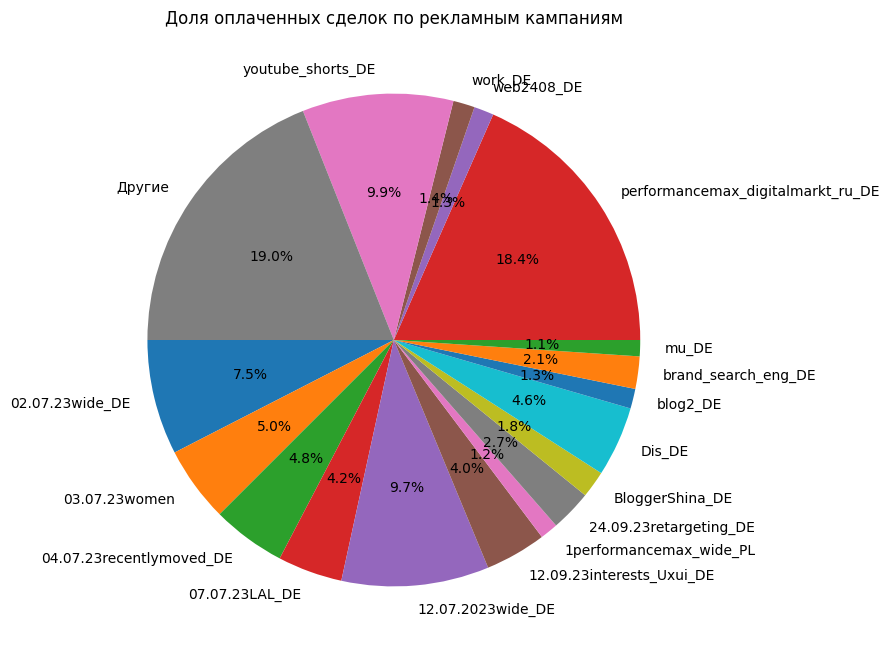

In [11]:
# Доля оплаченных сделок по кампаниям
# Рассчет общей суммы оплаченных сделок
total_payment_done = campaign_summary['payment_done_deals'].sum()

# Рассчет доли каждой кампании
campaign_summary['percentage'] = (campaign_summary['payment_done_deals'] / total_payment_done) * 100

# Группировка кампаний с долей менее 1% в категорию "Другие"
small_campaigns = campaign_summary[campaign_summary['percentage'] < 1]
other_total = small_campaigns['payment_done_deals'].sum()
other_percentage = small_campaigns['percentage'].sum()

# Создание новой таблицы, включающей только крупные кампании и категорию "Другие"
large_campaigns = campaign_summary[campaign_summary['percentage'] >= 1]
combined_campaigns = pd.concat([
    large_campaigns,
    pd.DataFrame({'campaign': ['Другие'], 'payment_done_deals': [other_total], 'percentage': [other_percentage]})
])

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(combined_campaigns['payment_done_deals'], labels=combined_campaigns['campaign'], autopct='%1.1f%%', startangle=180)
plt.title('Доля оплаченных сделок по рекламным кампаниям')
plt.show()

### На представленном круговом графике показана доля оплаченных сделок по различным рекламным кампаниям. Основные выводы из графика:

**Наиболее успешные кампании**:
Кампания *performancemax_digitalmarkt_ru_DE* занимает крупнейшую долю, составляя 18.4% всех оплаченных сделок. Это указывает на её высокую эффективность.
Кампания *youtube_shorts_DE* занимает вторую по величине долю (9.9%), что также демонстрирует её успешность.

**Распределение по другим кампаниям**:
Видно, что несколько кампаний, таких как *02.07.23wide_DE*, *03.07.23women*, *04.07.23recentlymoved_DE*, и *07.07.23LAL_DE*, имеют долю от 4.2% до 7.5%, что показывает их умеренную эффективность.
Кампании с долей ниже 4% сгруппированы в категорию "Другие", которая составляет 19% всех оплаченных сделок. Это указывает на то, что множество кампаний имеет небольшое влияние на общую сумму продаж.

**Разнообразие кампаний**:
График демонстрирует, что существует широкий спектр кампаний с разной степенью успеха. Некоторые из них заметно более эффективны, что может быть связано с целевой аудиторией, контентом, или каналами распространения.

**Выводы**:
Основное внимание следует уделить наиболее успешным кампаниям, таким как *performancemax_digitalmarkt_ru_DE* и *youtube_shorts_DE*, чтобы понять, что делает их более эффективными.
Кампании, сгруппированные в категорию "Другие", требуют дальнейшего анализа, чтобы определить, можно ли улучшить их эффективность или отказаться от тех, которые приносят наименьший результат.
Возможным направлением для оптимизации может быть перераспределение бюджетов из менее успешных кампаний в более успешные, а также тестирование новых стратегий на основе успешных практик.

Для расчета юнит-экономики и маржинальной прибыли, наиболее подходящей метрикой будет ***конверсия из созданных сделок в оплаченные сделки***. 
Эта метрика отражает реальное количество клиентов, которые прошли весь путь воронки и совершили оплату, что и определяет фактический доход от продаж.

*Почему именно эта конверсия важна*:
*Оплаченные сделки определяют реальный доход*: В отличие от других этапов воронки, именно оплаченные сделки генерируют выручку. 
Все предыдущие этапы (показы, клики, созданные сделки) являются промежуточными и могут не привести к доходу, если сделки не будут завершены.

*Фокус на маржинальную прибыль*: Маржинальная прибыль рассчитывается на основе дохода от каждой оплаченной сделки за вычетом 
связанных с ней затрат. Таким образом, конверсия, ведущая к реальным продажам, является критической для оценки прибыльности.

Данные по созданным сделкам и оплачиваемым сделкам для каждого продукта, распределение рекламных затрат можно провести 
следующим образом:

Распределение затрат на основе всех созданных сделок: В этом случае рекламные затраты будут распределяться пропорционально 
количеству всех созданных сделок. Это полезно, если вы хотите оценить, сколько денег было потрачено на привлечение каждого лида, 
независимо от того, был он оплачен или нет.

Распределение затрат на основе оплаченных сделок: Это даст представление о том, сколько денег было потрачено на каждого клиента, 
который в итоге совершил покупку. Это важно для оценки рентабельности маркетинговых усилий.

Комбинированный подход: Если нам нужно учитывать как созданные, так и оплаченные сделки, мы можем использовать весовой коэффициент 
для распределения затрат, учитывая оба аспекта.

In [12]:
#Группируем данные по рекламным кампаниям 

# сгруппировать данные в spend_df по рекламным кампаниям и найти общие значения по показам, кликам и затратам
grouped_spend = spend_df.groupby('campaign').agg(
    total_impressions=('impressions', 'sum'),
    total_clicks=('clicks', 'sum'),
    total_spend=('spend', 'sum')
).reset_index()

# Вывод результатов
print(grouped_spend)

total_sum = grouped_spend['total_spend'].sum()

# Вывести итоговую сумму
print("Итоговая сумма значений по столбцу 'total_spend':", total_sum)

                       campaign  total_impressions  total_clicks  total_spend
0       01.02.24wide_webinar_DE              18271           333       193.38
1              01.04.23women_PL              53650           635       447.00
2               02.05.24test_DE              21365           848       224.04
3               02.07.23wide_DE             775166         25558     10266.02
4          02.08.23interests_DE               6827           370        81.30
5                 03.07.23women             495999         17370      7665.01
6      04.07.23recentlymoved_DE             581378         18648      6635.37
7          05.07.23interests_DE              52786          1548       584.81
8             05.09.2023wide_DE              90292          1776       466.11
9                07.07.23LAL_DE             452092         14552      8332.44
10              07.12.23test_DE              33939          1251       523.26
11      08.04.24wide_webinar_DE             137386          2001

### В представленной таблице приведены данные о рекламных кампаниях, включая количество показов (impressions), количество кликов (clicks), и общие расходы на рекламу (spend). Вот несколько ключевых моментов анализа:

**Основные выводы**:
**Разброс затрат на кампании**:
Кампании значительно варьируются по расходам: от минимальных значений, таких как 193.38 и 202.46 (например, *01.02.24wide_webinar_DE* и *01.04.23women_PL*), до максимальных значений, таких как 15783.98 (например, *youtube_shorts_DE*).
Общая сумма затрат по всем кампаниям составляет 149523.45, что свидетельствует о значительных вложениях в маркетинг.

**Эффективность кампаний (на основе кликов)**:
Некоторые кампании с большими расходами также показывают высокое количество кликов, например, *02.07.23wide_DE* (25588 кликов при затратах 6326.82) и *youtube_shorts_DE* (1141 кликов при затратах 270.50).
Однако, другие кампании, такие как *15.11.23wide_webinar_DE*, имеют относительно небольшое количество кликов (2295 кликов) при довольно высоких расходах (8853.88).

**Расходы и клики**:
Есть кампании, где расходы и количество кликов соотносятся адекватно, например, *01.02.24wide_webinar_DE* с 333 кликами и 193.38 затрат.
Есть кампании, где расходы высокие, но количество кликов не оправдывает затраты, например, *20.03.24wide_PL* с 233 кликами и затратами в 1207.45.

**Концентрация расходов**:
Наиболее затратные кампании включают *youtube_shorts_DE* (15783.98), *performancemax_wide_AT* (13172.98) и *performancemax_wide_PL* (3512.49).
Эти кампании могут быть высокоэффективными в плане привлечения трафика, однако требует дальнейшего анализа для понимания их рентабельности.

**Рекомендации**:
*Оптимизация затрат*: Необходимо проанализировать кампании с высокими затратами и низким количеством кликов, чтобы оптимизировать бюджет и перераспределить его на более эффективные кампании.
*Улучшение эффективности*: Стоит обратить внимание на кампании с высоким количеством кликов при низких затратах, чтобы масштабировать их.
*Глубокий анализ*: Провести более глубокий анализ эффективности каждой кампании с точки зрения полученных результатов (например, конверсий), а не только кликов.

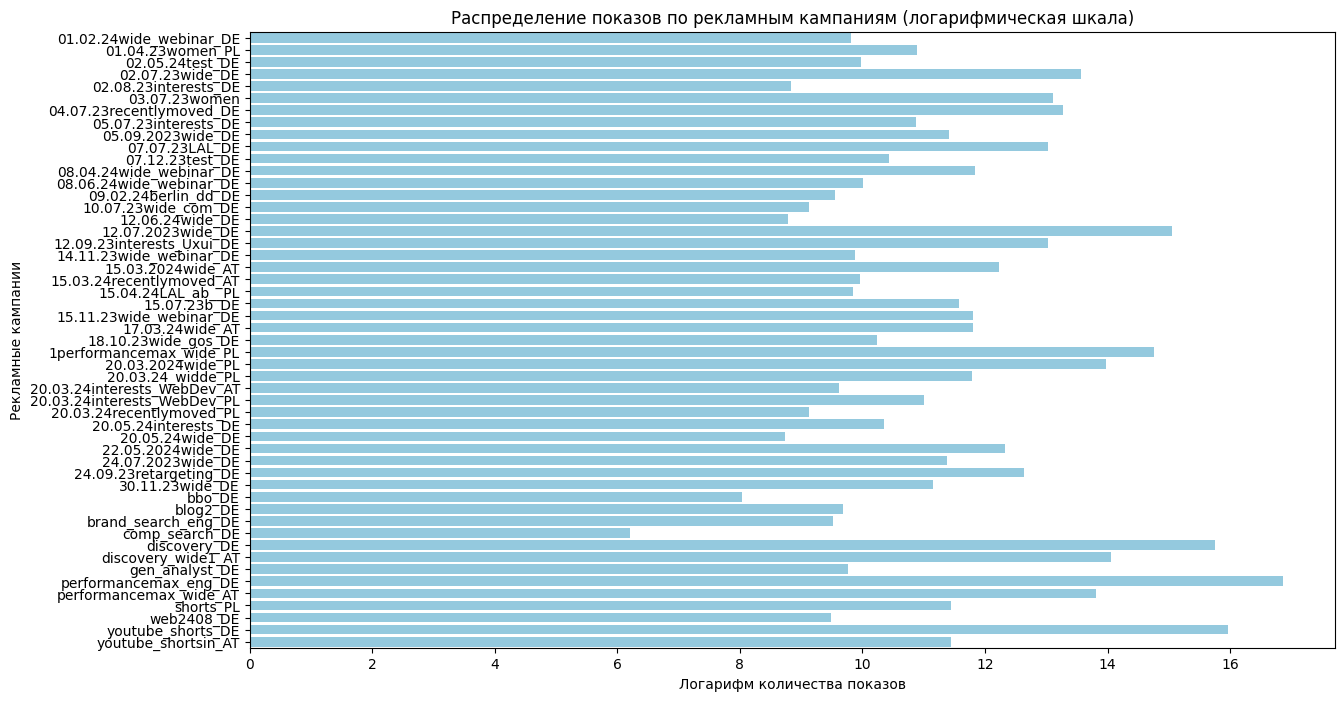

In [13]:
#Распределение показов по кампаниям:

# Преобразование количества показов в логарифмическую шкалу
grouped_spend['log_total_impressions'] = np.log1p(grouped_spend['total_impressions'])  # Используем log1p, чтобы избежать логарифма от нуля

plt.figure(figsize=(14, 8))
sns.barplot(x='log_total_impressions', y='campaign', data=grouped_spend, color='skyblue')
plt.title('Распределение показов по рекламным кампаниям (логарифмическая шкала)')
plt.xlabel('Логарифм количества показов')
plt.ylabel('Рекламные кампании')
plt.show()

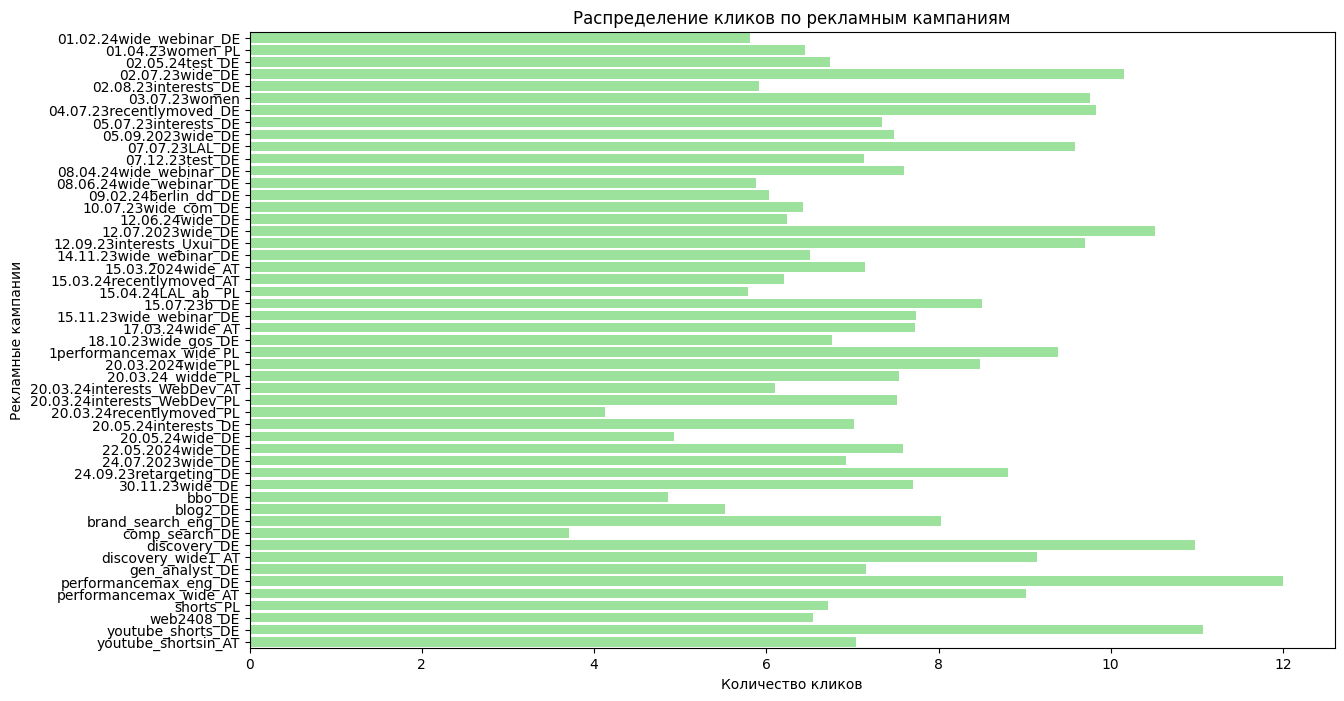

In [14]:
#Распределение кликов по кампаниям:

# Преобразование количества показов в логарифмическую шкалу
grouped_spend['log_total_clicks'] = np.log1p(grouped_spend['total_clicks'])  # Используем log1p, чтобы избежать логарифма от нуля

plt.figure(figsize=(14, 8))
sns.barplot(x='log_total_clicks', y='campaign', data=grouped_spend, color='lightgreen')
plt.title('Распределение кликов по рекламным кампаниям')
plt.xlabel('Количество кликов')
plt.ylabel('Рекламные кампании')
plt.show()

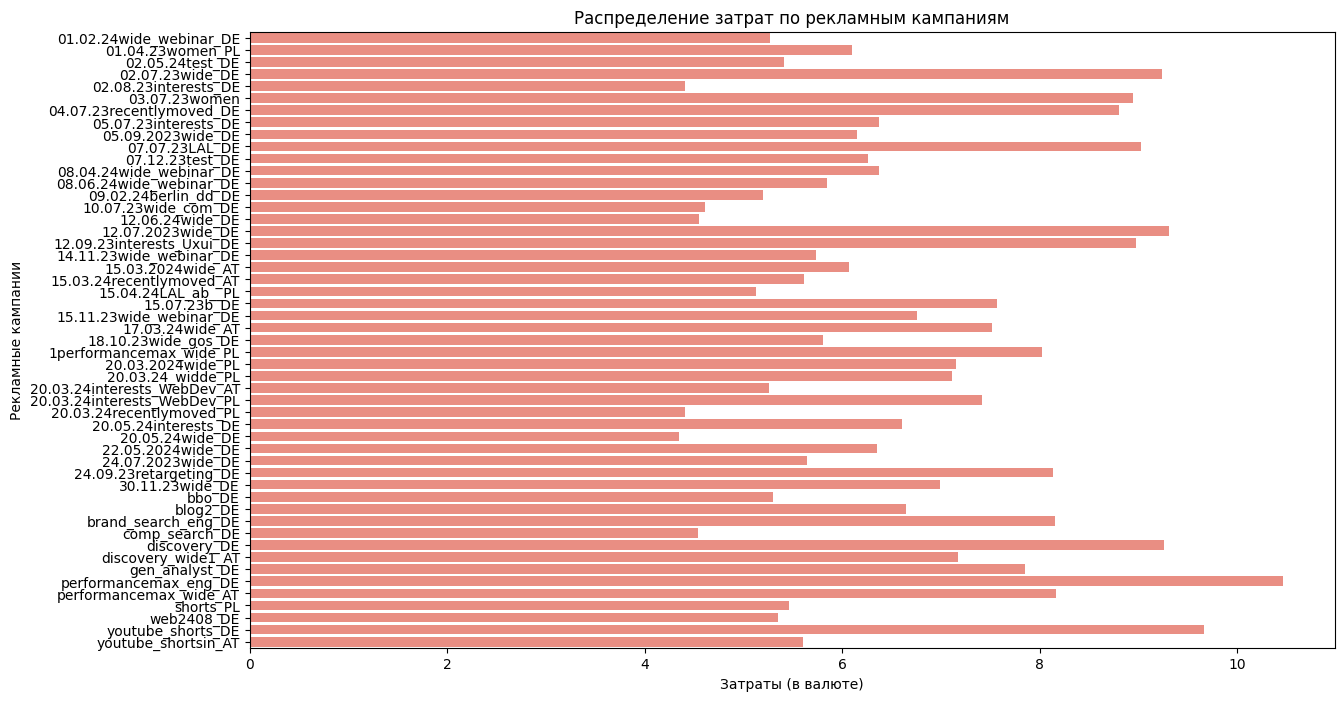

In [15]:
#Распределение затрат по кампаниям:

# Преобразование количества показов в логарифмическую шкалу
grouped_spend['log_total_spend'] = np.log1p(grouped_spend['total_spend'])  # Используем log1p, чтобы избежать логарифма от нуля

plt.figure(figsize=(14, 8))
sns.barplot(x='log_total_spend', y='campaign', data=grouped_spend, color='salmon')
plt.title('Распределение затрат по рекламным кампаниям')
plt.xlabel('Затраты (в валюте)')
plt.ylabel('Рекламные кампании')
plt.show()

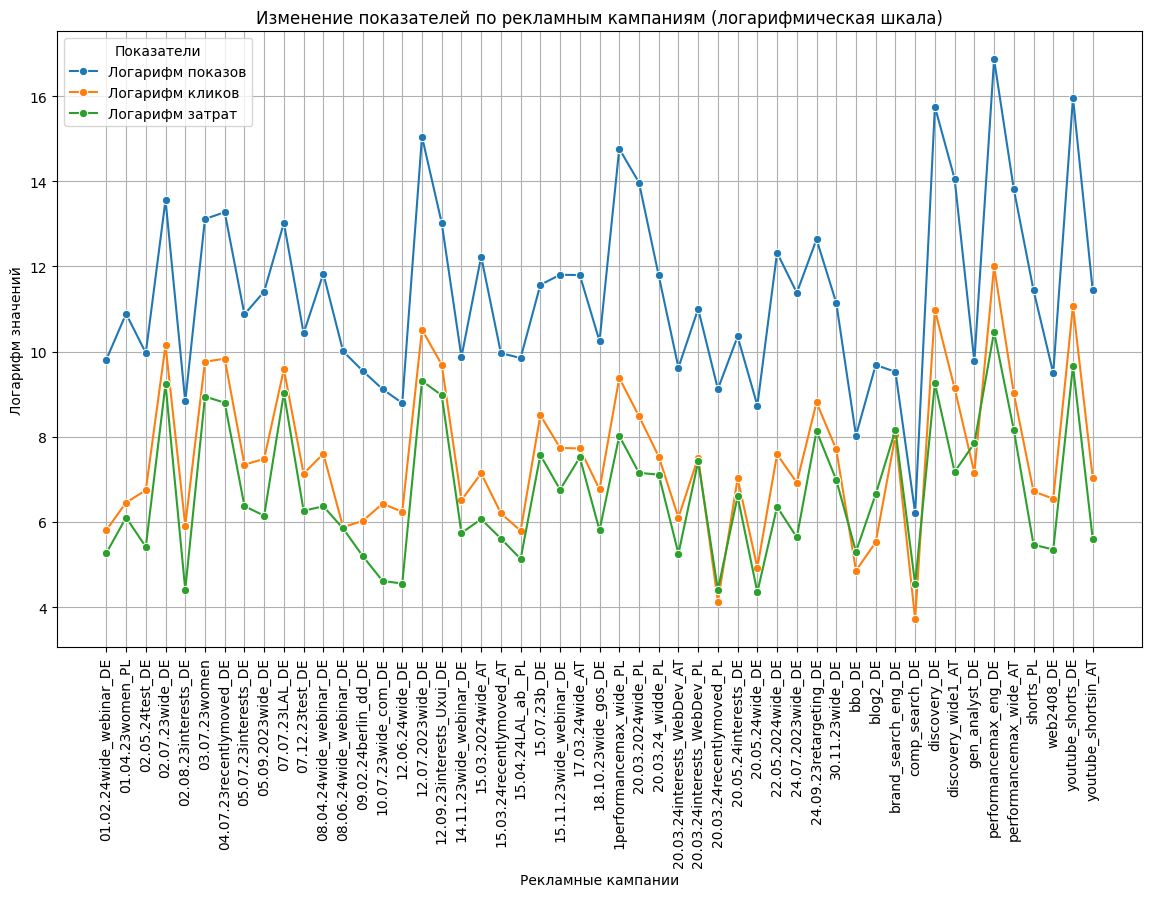

In [16]:
#Изменение показов, кликов и затрат по кампаниям:

# Преобразование данных в логарифмическую шкалу
grouped_spend['log_total_impressions'] = np.log1p(grouped_spend['total_impressions'])
grouped_spend['log_total_clicks'] = np.log1p(grouped_spend['total_clicks'])
grouped_spend['log_total_spend'] = np.log1p(grouped_spend['total_spend'])

plt.figure(figsize=(14, 8))
sns.lineplot(x='campaign', y='log_total_impressions', data=grouped_spend, marker='o', label='Логарифм показов')
sns.lineplot(x='campaign', y='log_total_clicks', data=grouped_spend, marker='o', label='Логарифм кликов')
sns.lineplot(x='campaign', y='log_total_spend', data=grouped_spend, marker='o', label='Логарифм затрат')
plt.title('Изменение показателей по рекламным кампаниям (логарифмическая шкала)')
plt.xlabel('Рекламные кампании')
plt.ylabel('Логарифм значений')
plt.xticks(rotation=90)
plt.legend(title='Показатели')
plt.grid(True)
plt.show()

### На представленном графике показаны изменения основных показателей по рекламным кампаниям в логарифмической шкале.

**Логарифмическая шкала**:

Применение логарифмической шкалы позволяет лучше визуализировать различия между кампаниями, особенно когда данные варьируются в широком диапазоне.
Основные показатели: количество показов, кликов и затраты, представлены в логарифмическом масштабе, что помогает выявить тенденции и сравнивать кампании, даже если разница между ними значительна.

**Изменение показателей**:

***Логарифм показов (синие точки)***: Данные показывают, что большинство кампаний имеют более высокие значения показов, что видно по скачкам на графике.
***Логарифм кликов (оранжевые точки)***: Некоторые кампании показывают высокую конверсию с показов на клики, хотя видно, что количество кликов значительно ниже, чем количество показов.
***Логарифм затрат (зеленые точки)***: Затраты на рекламу в большинстве случаев распределяются более равномерно, однако есть несколько кампаний с высокими затратами, что может указывать на их приоритет.

**Сравнение кампаний**:

Видно, что некоторые кампании имеют высокий логарифм показов, но низкие логарифмы кликов и затрат, что может указывать на низкую эффективность или недостаточное привлечение аудитории.
Кампании с высокими логарифмами затрат и кликов при относительно низких показах могут быть высокоэффективными с точки зрения конверсии.

**Рекомендации**:
Возможно, стоит пересмотреть стратегии для кампаний с высокими показами, но низкими кликами, чтобы повысить их эффективность.
Кампании с высокими затратами и низкими кликами требуют дополнительного анализа для понимания, почему они не приносят ожидаемого результата.

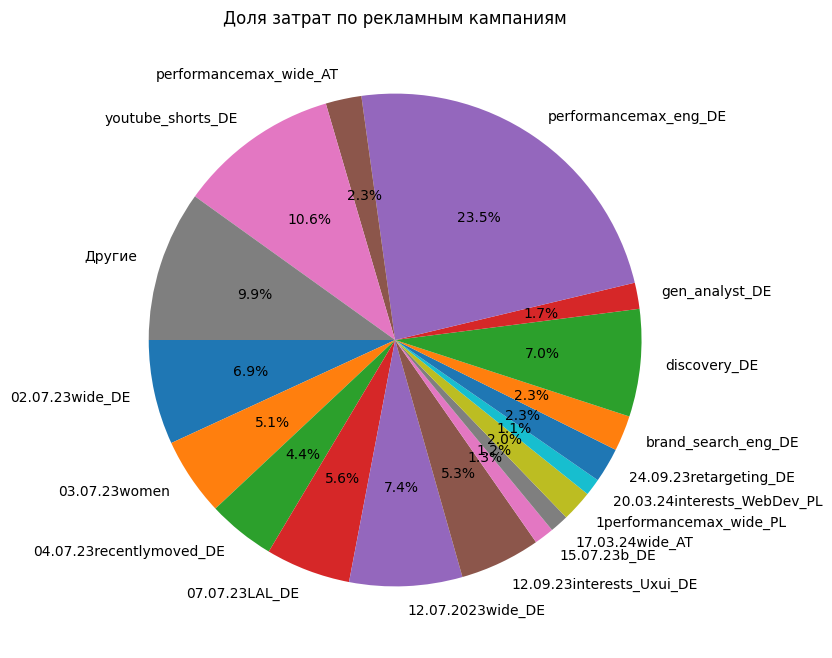

In [17]:
#Круговая диаграмма: Доля затрат по рекламным кампаниям:
grouped_spend['spend_percentage'] = grouped_spend['total_spend'] / grouped_spend['total_spend'].sum()

# Отдельно выделим кампании с долей затрат менее 1% и остальные
small_spends = grouped_spend[grouped_spend['spend_percentage'] < 0.01]
large_spends = grouped_spend[grouped_spend['spend_percentage'] >= 0.01]

# Суммируем затраты для кампаний с долей менее 1% и создаем категорию "Другие"
other_spend = small_spends['total_spend'].sum()
other_row = pd.DataFrame({'campaign': ['Другие'], 'total_spend': [other_spend]})

# Объединяем обратно крупные кампании и "Другие"
final_spend = pd.concat([large_spends[['campaign', 'total_spend']], other_row], ignore_index=True)

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(final_spend['total_spend'], labels=final_spend['campaign'], autopct='%1.1f%%', startangle=180)
plt.title('Доля затрат по рекламным кампаниям')
plt.show()

### На представленном круговом графике показано распределение затрат по рекламным кампаниям.
### Основные выводы анализа:

**Основные доли**:
Кампания *performancemax_eng_DE* занимает самую большую долю затрат — 23.5% от общего бюджета. Это указывает на значительное вложение в эту кампанию.
Другие крупные кампании включают *youtube_shorts_DE* (10.6%) и *performancemax_wide_AT* (10.5%).

**Малые доли и категория "Другие"**:
Кампании, которые попали в категорию *"Другие"*, составляют 9.9% от общих затрат, что объединяет менее значимые кампании с точки зрения затрат.
Категория "Другие" включает кампании с затратами менее 1%, что позволяет улучшить визуализацию и выделить наиболее значимые кампании.

**Разнообразие вложений**:
Вложения в рекламные кампании распределены относительно равномерно, однако наблюдаются значительные различия между крупными и мелкими кампаниями.
Такой анализ позволяет увидеть, какие кампании являются ключевыми с точки зрения затрат и требуют особого внимания при оценке их эффективности.

**Рекомендации**:
Для кампаний с высокой долей затрат важно провести дальнейший анализ их эффективности, чтобы убедиться, что они приносят ожидаемую отдачу.
Кампании с низкими затратами могут быть проанализированы на предмет их возможного повышения эффективности или оптимизации.

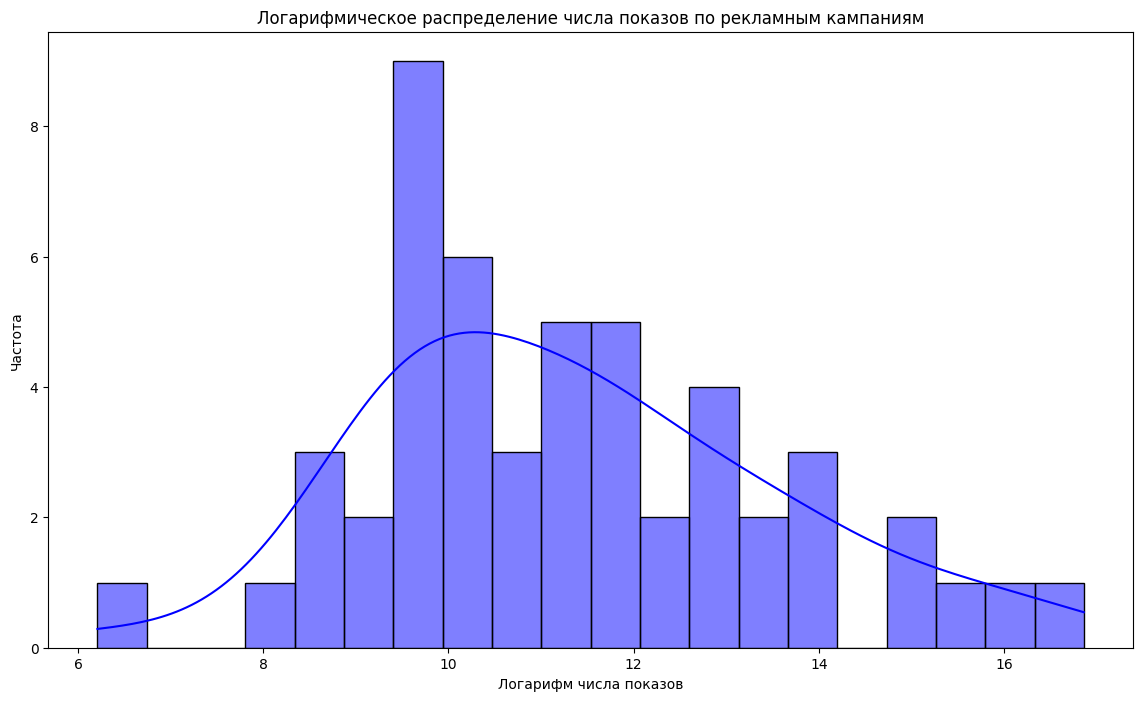

In [18]:
#Распределение числа показов по кампаниям:

# Применяем логарифм к данным о показах
log_impressions = np.log(grouped_spend['total_impressions'] + 1)  # Добавляем 1, чтобы избежать логарифма от 0

# Построение гистограммы с логарифмическим распределением
plt.figure(figsize=(14, 8))
sns.histplot(log_impressions, bins=20, kde=True, color='blue')
plt.title('Логарифмическое распределение числа показов по рекламным кампаниям')
plt.xlabel('Логарифм числа показов')
plt.ylabel('Частота')
plt.show()

### На графике представлено логарифмическое распределение числа показов по рекламным кампаниям. Основные моменты анализа:

**Распределение данных**:
Распределение показов имеет асимметричную форму с наибольшей частотой в диапазоне от 10 в 10й степени до 10ти в 11ой степени показов.
На графике видно, что большинство кампаний имеют количество показов в указанном логарифмическом диапазоне, что свидетельствует о более концентрированном распределении показов.

**Редкие и популярные кампании**:
Некоторое количество кампаний находятся в диапазоне более низких показов (ниже 10ти в 8й степени) и более высоких (выше 10-ти в 14ой степени ).
Это может говорить о том, что несколько кампаний получают значительно меньше или значительно больше показов по сравнению с остальными.

**Анализ хвостов распределения**:
Кампании, находящиеся в хвостах распределения, требуют дополнительного внимания. Либо они недостаточно эффективны и получают мало показов, либо они слишком доминируют, что может говорить о несбалансированности маркетинговой стратегии.

**Возможные действия**:
Проанализировать кампании с экстремальными значениями, чтобы понять, стоит ли перераспределить бюджеты для улучшения общей эффективности.
Рассмотреть, как распределение показов соотносится с конверсиями и другими ключевыми показателями эффективности.

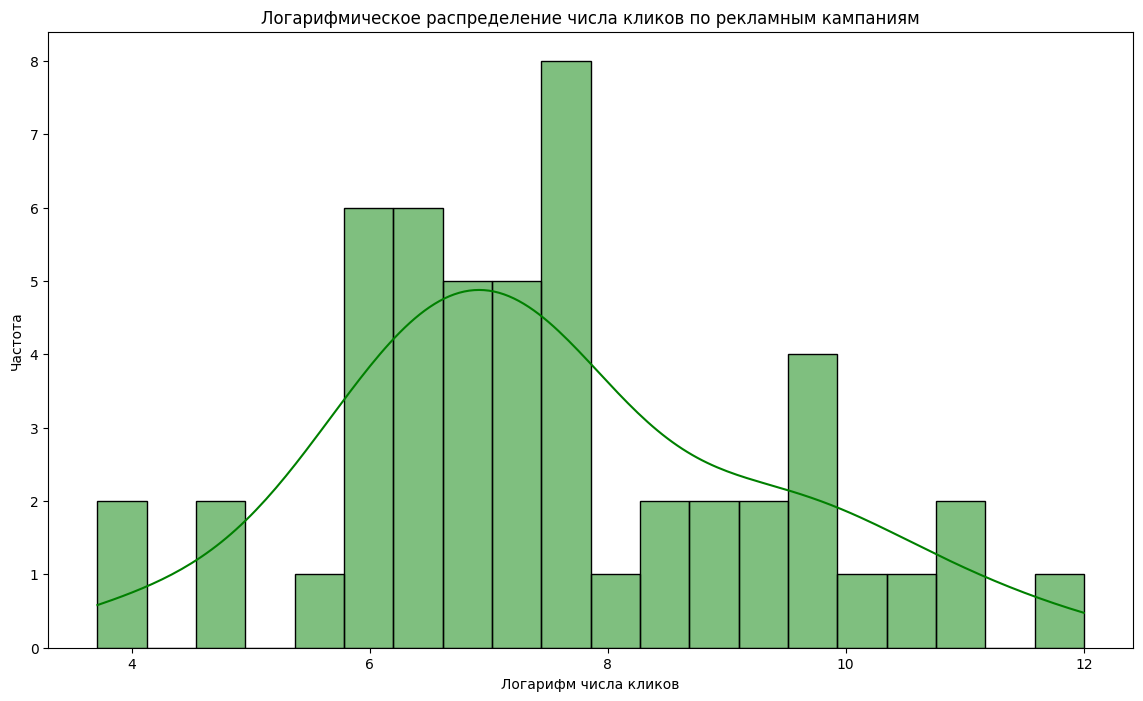

In [19]:
#Распределение числа кликов по кампаниям:

# Применяем логарифм к данным о кликах
log_clicks = np.log(grouped_spend['total_clicks'] + 1)  # Добавляем 1, чтобы избежать логарифма от 0

# Построение гистограммы с логарифмическим распределением
plt.figure(figsize=(14, 8))
sns.histplot(log_clicks, bins=20, kde=True, color='green')
plt.title('Логарифмическое распределение числа кликов по рекламным кампаниям')
plt.xlabel('Логарифм числа кликов')
plt.ylabel('Частота')
plt.show()

### На графике представлено логарифмическое распределение числа кликов по рекламным кампаниям. Основные моменты анализа:

**Распределение данных**:
Распределение кликов по кампаниям имеет несколько пиков, с наибольшей частотой кликов в диапазоне от 10ти в 6й степени до 10ти в 8й степени.
Видны два основных диапазона концентрации кликов: от 10ти в 6й степени до 10ти в 7й степени и от от 10ти в 8й степени до 10ти в 9й степени.

**Редкие и популярные кампании**:
Есть несколько кампаний с низким количеством кликов (меньше 10ти в 5й степени), а также некоторые с очень высоким числом кликов (более 10ти в 11й степени).
Это указывает на то, что некоторые кампании значительно более успешны в привлечении кликов, чем другие.

**Анализ хвостов распределения**:
Кампании с крайними значениями могут потребовать дополнительного анализа. Кампании с низким количеством кликов возможно нуждаются в оптимизации, тогда как те, что находятся на верхнем конце распределения, могли бы использоваться как примеры лучших практик.

**Возможные действия**:
Определить, что способствует высокой кликабельности в определенных кампаниях и можно ли применить эти стратегии к менее успешным кампаниям.
Перераспределение бюджетов и усилий на основании эффективности кликов для оптимизации рекламных затрат.

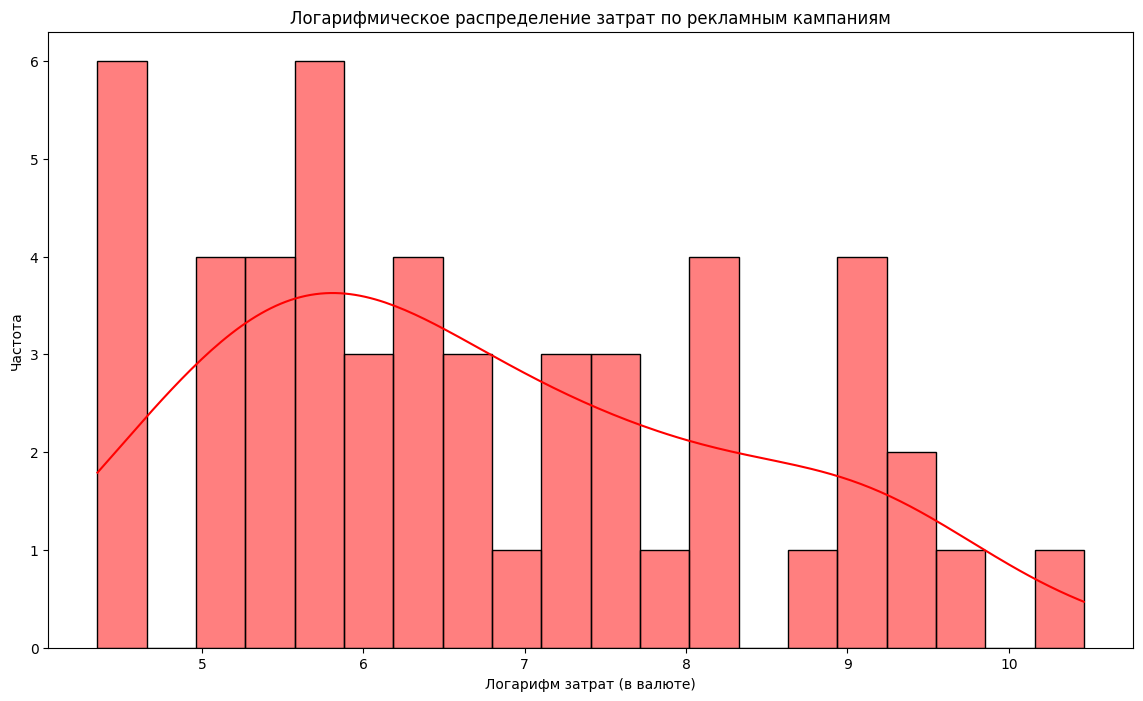

In [20]:
#Распределение затрат по кампаниям:

# Применяем логарифм к данным о затратах
log_spend = np.log(grouped_spend['total_spend'] + 1)  # Добавляем 1, чтобы избежать логарифма от 0

# Построение гистограммы с логарифмическим распределением
plt.figure(figsize=(14, 8))
sns.histplot(log_spend, bins=20, kde=True, color='red')
plt.title('Логарифмическое распределение затрат по рекламным кампаниям')
plt.xlabel('Логарифм затрат (в валюте)')
plt.ylabel('Частота')
plt.show()

### На графике представлено логарифмическое распределение затрат по рекламным кампаниям. Основные моменты анализа:

**Распределение затрат**:
Большая часть кампаний имеет логарифм затрат в диапазоне от 5 до 8, что указывает на умеренные расходы.
На графике также есть кампании с более низкими и высокими затратами, но они менее многочисленны.

**Пик распределения**:
Максимальная частота наблюдается в диапазоне от 5 до 6, что свидетельствует о том, что большинство кампаний сосредоточено в этой категории расходов.
Снижение частоты для более высоких значений логарифма указывает на меньшее количество кампаний с очень высокими затратами.

**Анализ хвостов распределения**:
Кампании с высокими затратами (с логарифмом выше 8) могут быть объектом дальнейшего анализа для оценки их эффективности по сравнению с затратами.
Низкие затраты (логарифм ниже 5) могут указывать на небольшие тестовые кампании или на менее успешные маркетинговые усилия.

**Рекомендации**:
Проанализировать кампании с самыми высокими и низкими затратами, чтобы оценить их рентабельность и возможные улучшения.
Использовать полученные данные для оптимизации бюджета и улучшения общего маркетингового эффекта.

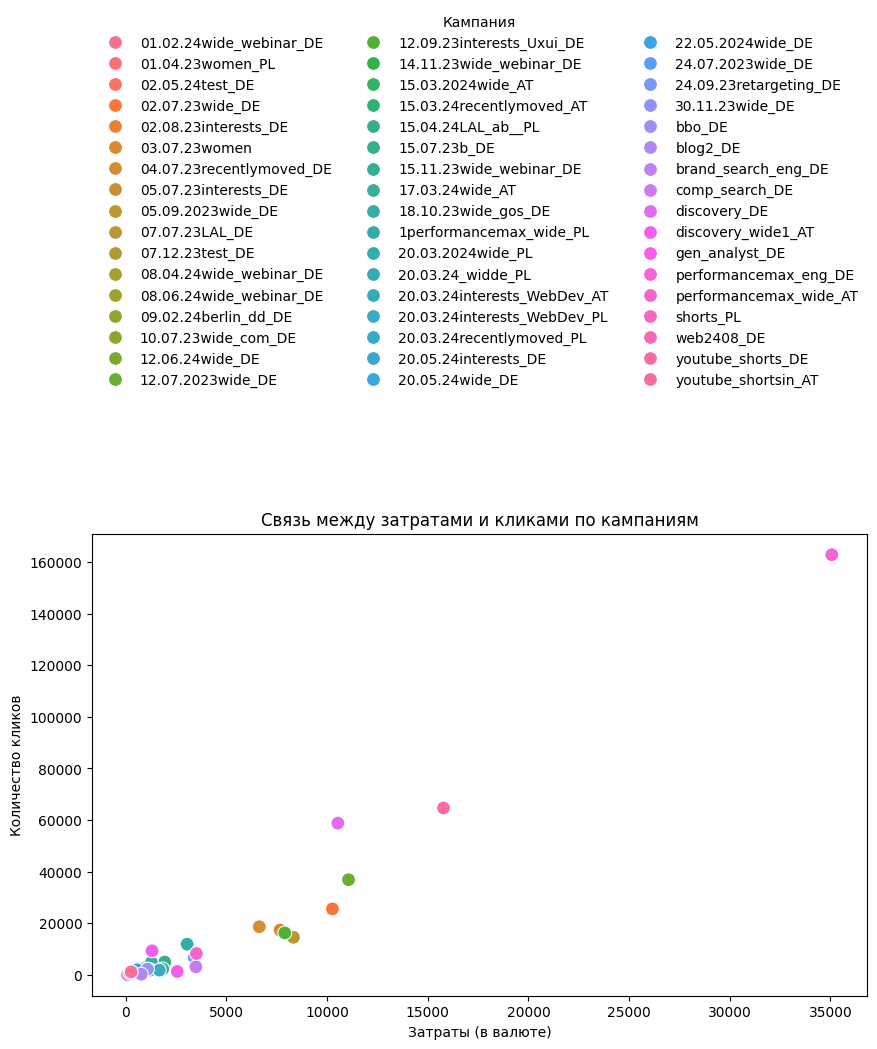

In [21]:
#Scatter Plot (Диаграмма рассеяния): Связь между затратами и кликами

plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_spend', y='total_clicks', data=grouped_spend, hue='campaign', s=100)

plt.title('Связь между затратами и кликами по кампаниям')
plt.xlabel('Затраты (в валюте)')
plt.ylabel('Количество кликов')

# Настройка легенды
plt.legend(title='Кампания', bbox_to_anchor=(0.5, 2.15), loc='upper center', ncol=3, frameon=False)

plt.show()

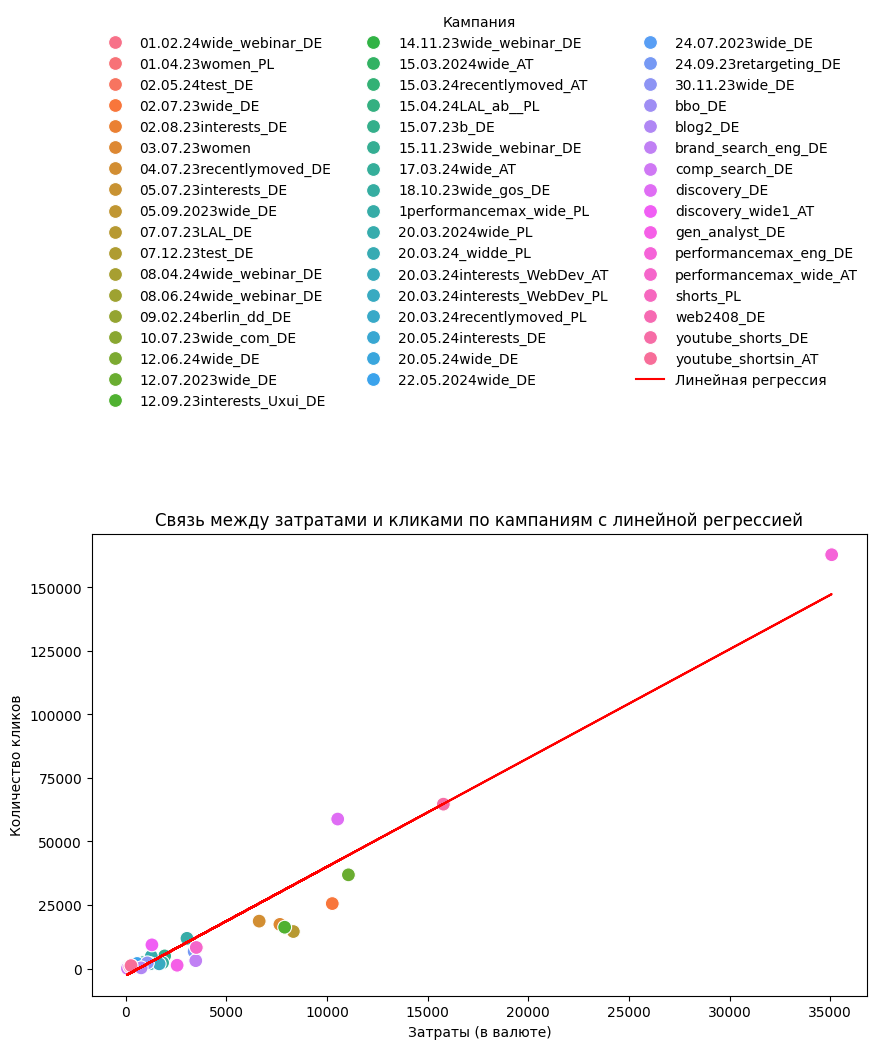

In [22]:
from sklearn.linear_model import LinearRegression

# Создание фигуры
plt.figure(figsize=(10, 6))

# Построение scatterplot
sns.scatterplot(x='total_spend', y='total_clicks', data=grouped_spend, hue='campaign', s=100)

# Линейная регрессия
X = grouped_spend['total_spend'].values.reshape(-1, 1)
y = grouped_spend['total_clicks'].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Добавление линии линейной регрессии на график
plt.plot(grouped_spend['total_spend'], y_pred, color='red', label='Линейная регрессия')

# Настройка заголовка и осей
plt.title('Связь между затратами и кликами по кампаниям с линейной регрессией')
plt.xlabel('Затраты (в валюте)')
plt.ylabel('Количество кликов')

# Настройка легенды
plt.legend(title='Кампания', bbox_to_anchor=(0.5, 2.15), loc='upper center', ncol=3, frameon=False)

# Показ графика
plt.show()

### На графике представлена связь между затратами на рекламные кампании и количеством кликов по ним с добавлением линии линейной регрессии. Основные выводы:

**Прямая зависимость**:
Линия линейной регрессии показывает положительную зависимость: с увеличением затрат на рекламу количество кликов также увеличивается. Это подтверждает эффективность вложений в рекламные кампании в большинстве случаев.

**Разброс данных**:
Большинство данных расположено вдоль линии регрессии, что говорит о том, что большинство кампаний соответствуют этой тенденции.
Есть несколько точек, которые значительно отклоняются от линии. Эти аномалии могут быть следствием неэффективных кампаний, которые требуют дополнительного анализа.

**Высокие расходы и клики**:
Кампании с самыми высокими расходами показывают пропорционально высокое количество кликов, что предполагает, что большие бюджеты на рекламу в данном случае окупаются.

**Рекомендации**:
Следует внимательно рассмотреть кампании, отклоняющиеся от линии регрессии, чтобы понять причины их неэффективности или, напротив, сверхэффективности.
Этот анализ помогает определить оптимальные уровни затрат для достижения максимального количества кликов.

In [23]:

# Объединение датафреймов по рекламным кампаниям
merged_df = pd.merge(deals_df, grouped_spend, on='campaign', how='left')

# Добавление столбца с флагом, который указывает на первое вхождение каждой кампании
merged_df['first_occurrence'] = merged_df.duplicated(subset=['campaign'], keep='first')

# Оставляем расходы только для первого вхождения каждой кампании, остальные значения заполняем NaN
merged_df.loc[merged_df['first_occurrence'] == True, 'total_spend'] = np.nan

# Удаление вспомогательного столбца, так как он больше не нужен
merged_df.drop(columns=['first_occurrence'], inplace=True)

# Вывод результата
print(merged_df.head())

grouped_final = merged_df.groupby('id').agg(
    total_spend=('total_spend', 'sum'),  # Суммирование затрат на рекламу
    
).reset_index()

# Пересчитываем итоговые затраты на рекламу по всей таблице (например, для анализа)
total_ad_spend = grouped_final['total_spend'].sum()

# Выводим итоговые затраты на рекламу
print("Итоговые затраты на рекламу:", total_ad_spend)

                    id deal owner name        closing date            quality  \
0  5805028000056864768        Ben Hall 2024-06-20 23:45:36            C - Low   
1  5805028000056859648   Ulysses Adams 2024-06-21 00:00:00  E - Non Qualified   
2  5805028000056832000   Ulysses Adams 2024-06-21 00:00:00     D - Non Target   
3  5805028000056823808        Eva Kent 2024-06-21 00:00:00  E - Non Qualified   
4  5805028000056872960        Ben Hall 2024-06-21 00:00:00     D - Non Target   

      stage                  lost reason       page  \
0  New Lead               Invalid number  /eng/test   
1  New Lead  Conditions are not suitable    /at-eng   
2      Lost                   Non target    /at-eng   
3      Lost               Invalid number       /eng   
4      Lost                   Non target       /eng   

                            campaign       sla                  ad  ...  \
0                      03.07.23women       NaN                 v16  ...   
1  performancemax_digitalmarkt_r

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21502 entries, 0 to 21501
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     21502 non-null  int64         
 1   deal owner name        21502 non-null  object        
 2   closing date           21502 non-null  datetime64[ns]
 3   quality                21502 non-null  object        
 4   stage                  21502 non-null  object        
 5   lost reason            21502 non-null  object        
 6   page                   21502 non-null  object        
 7   campaign               21502 non-null  object        
 8   sla                    15463 non-null  object        
 9   ad                     14119 non-null  object        
 10  adgroup                12426 non-null  object        
 11  source                 21502 non-null  object        
 12  payment type           21502 non-null  object        
 13  p

In [25]:
#расчет количества сделок и "Payment Done" по каждому продукту
# Группировка по продукту и расчет количества сделок

product_deals_summary = merged_df.groupby('product').agg(
    total_deals=('id', 'count'),  # Общее количество сделок
    payment_done_deals=('stage', lambda x: x.isin(['Payment Done', 'Registered on Webinar', 'Registered on Offline Day']).sum())).reset_index()

print(product_deals_summary)

               product  total_deals  payment_done_deals
0       Data Analytics           10                   0
1    Digital Marketing        13165                1648
2  Find yourself in IT          103                   1
3         UX/UI Design         5738                 919
4        Web Developer         2486                 451


In [26]:
# Расчет конверсии
# Группировка всех сделок по продуктам
product_deals_summary = deals_df.groupby('product').agg(
    total_deals=('id', 'count')  # Общее количество сделок
).reset_index()

# Группировка только завершенных сделок по продуктам
completed_deals = deals_df[deals_df['stage'].isin(['Payment Done', 'Registered on Webinar', 'Registered on Offline Day'])]

payment_done_summary = completed_deals.groupby('product').agg(
    payment_done_deals=('id', 'count')  # Количество оплаченных сделок
).reset_index()

# Объединение двух датафреймов для получения полных данных по сделкам и успешным сделкам
product_deals_summary = pd.merge(product_deals_summary, payment_done_summary, on='product', how='left')

# Расчет конверсии
product_deals_summary['conversion_rate %'] = (product_deals_summary['payment_done_deals'] / product_deals_summary['total_deals']) * 100

# Группировка завершенных сделок по продуктам для расчета среднего чека (AOV)
product_revenue_summary = completed_deals.groupby('product').agg(
    total_revenue=('offer total amount', 'sum'),  # Общий доход
    total_orders=('id', 'count')  # Количество заказов
).reset_index()

# Расчет среднего чека (AOV)
product_revenue_summary['AOV'] = product_revenue_summary['total_revenue'] / product_revenue_summary['total_orders']

# Объединение с product_deals_summary для добавления AOV и total_revenue
product_deals_summary = pd.merge(product_deals_summary, product_revenue_summary[['product', 'total_orders', 'total_revenue', 'AOV']], on='product', how='left')

# Вывод результата
display(product_deals_summary)

,product,total_deals,payment_done_deals,conversion_rate %,total_orders,total_revenue,AOV
0,Data Analytics,10,NaN,NaN,NaN,NaN,NaN
1,Digital Marketing,13165,1648.0,12.518040,1648.0,15627500.0,9482.706311
2,Find yourself in IT,103,1.0,0.970874,1.0,1.0,1.000000
3,UX/UI Design,5738,919.0,16.016033,919.0,8811400.0,9588.030468
4,Web Developer,2486,451.0,18.141593,451.0,3349600.0,7427.050998


## На основе представленной таблицы можно сделать следующие выводы:

**Конверсия и успешные сделки**:
Продукт *"Digital Marketing"* лидирует по количеству успешных сделок (1648) и имеет конверсию в 12,52%. Это показывает, что он привлекает 
больше всего клиентов и демонстрирует значительный успех на рынке.
*"UX/UI Design"* также показывает хорошую конверсию (16,02%) и успешные сделки (919), что делает его вторым по успешности продуктом.
Продукт *"Web Developer"* имеет наивысшую конверсию (18,14%) среди продуктов, что свидетельствует о высоком уровне успеха сделок для этого продукта.

**Средний чек (AOV)**:
Продукт с наивысшим средним чеком (AOV) — *"UX/UI Design"* (9588,03), за ним следует *"Digital Marketing"* (9482,71).
Продукт *"Web Developer"* имеет относительно высокий средний чек — 7427,05.
Продукт *"Find yourself in IT"* имеет самый низкий средний чек — 1.00, что, вероятно, связано с малым количеством успешных сделок (только 1).

**Проблемные продукты**:
Продукт *"Data Analytics"* не имеет успешных сделок (конверсия 0%), что может свидетельствовать о проблемах с предложением или целевым рынком для этого продукта.
Продукт *"Find yourself in IT"* также показывает низкую конверсию и всего одну успешную сделку, что требует внимания и, возможно, пересмотра стратегии продаж или продукта.

**Вывод**:
В целом, анализ показывает, что *"Digital Marketing"* и *"UX/UI Design"* являются лидерами как по объему продаж, так и по эффективности сделок, в то время как *"Data Analytics"* и *"Find yourself in IT"* требуют пересмотра для повышения их успешности на рынке.

In [27]:
#расчет COGS
# Фильтрация данных для завершенных сделок
completed_deals = deals_df[deals_df['stage'].isin(['Payment Done', 'Registered on Webinar', 'Registered on Offline Day'])]

# Группировка данных по продуктам для расчета COGS
product_cogs_summary = merged_df.groupby('product').agg(
    total_revenue=('offer total amount', 'sum'),  # Общий доход
    total_orders=('id', 'count'),  # Количество заказов
    total_advertising_cost=('total_spend', 'sum')  # Общая рекламная стоимость
).reset_index()

# Расчет COGS на единицу продукции
product_cogs_summary['COGS_per_unit'] = product_cogs_summary['total_advertising_cost'] / product_cogs_summary['total_orders']

# Объединение с основной таблицей product_deals_summary
product_deals_summary = pd.merge(product_deals_summary, product_cogs_summary[['product', 'COGS_per_unit', 'total_advertising_cost']], on='product', how='left')

display(product_cogs_summary)

# Вывод результата
display(product_deals_summary)

,product,total_revenue,total_orders,total_advertising_cost,COGS_per_unit
0,Data Analytics,6000.0,10,0.00,0.000000
1,Digital Marketing,122858224.0,13165,5291.53,0.401939
2,Find yourself in IT,1013001.0,103,1308.18,12.700777
3,UX/UI Design,55074200.0,5738,6540.03,1.139775
4,Web Developer,20417800.0,2486,133370.01,53.648435


,product,total_deals,payment_done_deals,conversion_rate %,total_orders,total_revenue,AOV,COGS_per_unit,total_advertising_cost
0,Data Analytics,10,NaN,NaN,NaN,NaN,NaN,0.000000,0.00
1,Digital Marketing,13165,1648.0,12.518040,1648.0,15627500.0,9482.706311,0.401939,5291.53
2,Find yourself in IT,103,1.0,0.970874,1.0,1.0,1.000000,12.700777,1308.18
3,UX/UI Design,5738,919.0,16.016033,919.0,8811400.0,9588.030468,1.139775,6540.03
4,Web Developer,2486,451.0,18.141593,451.0,3349600.0,7427.050998,53.648435,133370.01


In [28]:
#APC (Average payment count) — это среднее число платежей
# Группировка данных по продуктам для расчета APC
product_apc_summary = completed_deals.groupby('product').agg(
    total_payments=('id', 'count'),  # Общее количество платежей
    total_orders=('id', 'nunique')  # Количество уникальных заказов (или клиентов)
).reset_index()

# Расчет среднего количества платежей на одну сделку (APC)
product_apc_summary['APC'] = product_apc_summary['total_payments'] / product_apc_summary['total_orders']

# Объединение с основным датафреймом product_deals_summary
product_deals_summary = pd.merge(product_deals_summary, product_apc_summary[['product', 'APC']], on='product', how='left')

# Вывод результата
display(product_deals_summary)

,product,total_deals,payment_done_deals,conversion_rate %,total_orders,total_revenue,AOV,COGS_per_unit,total_advertising_cost,APC
0,Data Analytics,10,NaN,NaN,NaN,NaN,NaN,0.000000,0.00,NaN
1,Digital Marketing,13165,1648.0,12.518040,1648.0,15627500.0,9482.706311,0.401939,5291.53,1.342020
2,Find yourself in IT,103,1.0,0.970874,1.0,1.0,1.000000,12.700777,1308.18,1.000000
3,UX/UI Design,5738,919.0,16.016033,919.0,8811400.0,9588.030468,1.139775,6540.03,1.265840
4,Web Developer,2486,451.0,18.141593,451.0,3349600.0,7427.050998,53.648435,133370.01,1.180628


In [29]:
# Приведение названий столбцов к нижнему регистру для унификации
deals_df.columns = deals_df.columns.str.lower()
spend_df.columns = spend_df.columns.str.lower()

# Группировка данных в spend_df по рекламным кампаниям и расчет общих значений по показам, кликам и затратам
grouped_spend = spend_df.groupby('campaign').agg(
    total_impressions=('impressions', 'sum'),
    total_clicks=('clicks', 'sum'),
    total_spend=('spend', 'sum')
).reset_index()

# Объединение данных из deals_df и grouped_spend по столбцу campaign
merged_df = pd.merge(deals_df, grouped_spend, on='campaign', how='left')

# Добавление столбца с флагом, который указывает на первое вхождение каждой кампании
merged_df['first_occurrence'] = merged_df.duplicated(subset=['campaign'], keep='first')

# Оставляем расходы только для первого вхождения каждой кампании, остальные значения заполняем NaN
merged_df.loc[merged_df['first_occurrence'] == True, 'total_spend'] = np.nan

# Удаление вспомогательного столбца, так как он больше не нужен
merged_df.drop(columns=['first_occurrence'], inplace=True)

# Группировка данных по продуктам и расчет затрат на рекламу
product_spend_summary = merged_df.groupby('product').agg(
    total_spend=('total_spend', 'sum')  # Общие затраты на рекламу по продукту
).reset_index()

# Объединение с product_deals_summary
product_deals_summary = pd.merge(product_deals_summary, product_spend_summary, on='product', how='left')

# Расчет CPA (Cost Per Acquisition)
product_deals_summary['CPA'] = product_deals_summary['total_spend'] / product_deals_summary['payment_done_deals']

# Расчет CAC (Customer Acquisition Cost)
product_deals_summary['CAC'] = product_deals_summary['CPA'] 

# Вывод результата
display(product_deals_summary)

# Пересчитываем итоговые затраты на рекламу по всей таблице (например, для анализа)
total_ad_spend = product_deals_summary['total_spend'].sum()

# Вывод общего объема затрат на рекламу
print(f'Общие затраты на рекламу: {total_ad_spend}')
#product_deals_summary.drop(columns=['total_spend_x', 'total_spend_y'], inplace=True)

,product,total_deals,payment_done_deals,conversion_rate %,total_orders,total_revenue,AOV,COGS_per_unit,total_advertising_cost,APC,total_spend,CPA,CAC
0,Data Analytics,10,NaN,NaN,NaN,NaN,NaN,0.000000,0.00,NaN,0.00,NaN,NaN
1,Digital Marketing,13165,1648.0,12.518040,1648.0,15627500.0,9482.706311,0.401939,5291.53,1.342020,5291.53,3.210880,3.210880
2,Find yourself in IT,103,1.0,0.970874,1.0,1.0,1.000000,12.700777,1308.18,1.000000,1308.18,1308.180000,1308.180000
3,UX/UI Design,5738,919.0,16.016033,919.0,8811400.0,9588.030468,1.139775,6540.03,1.265840,6540.03,7.116464,7.116464
4,Web Developer,2486,451.0,18.141593,451.0,3349600.0,7427.050998,53.648435,133370.01,1.180628,133370.01,295.720643,295.720643


Общие затраты на рекламу: 146509.75


In [30]:
# Расчет CPA (Cost Per Acquisition)
product_deals_summary['CPA'] = product_deals_summary['total_spend'] / product_deals_summary['payment_done_deals']

# Вычисление Contribution Margin с использованием COGS_per_unit
product_deals_summary['Contribution Margin'] = (
    product_deals_summary['total_deals'] * 
    (-product_deals_summary['CPA'] + 
    product_deals_summary['conversion_rate %'] / 100 * 
    (product_deals_summary['AOV'] - product_deals_summary['COGS_per_unit']) * 
    product_deals_summary['APC'])
)

# Вывод результата
display(product_deals_summary)

,product,total_deals,payment_done_deals,conversion_rate %,total_orders,total_revenue,AOV,COGS_per_unit,total_advertising_cost,APC,total_spend,CPA,CAC,Contribution Margin
0,Data Analytics,10,NaN,NaN,NaN,NaN,NaN,0.000000,0.00,NaN,0.00,NaN,NaN,NaN
1,Digital Marketing,13165,1648.0,12.518040,1648.0,15627500.0,9482.706311,0.401939,5291.53,1.342020,5291.53,3.210880,3.210880,2.092925e+07
2,Find yourself in IT,103,1.0,0.970874,1.0,1.0,1.000000,12.700777,1308.18,1.000000,1308.18,1308.180000,1308.180000,-1.347542e+05
3,UX/UI Design,5738,919.0,16.016033,919.0,8811400.0,9588.030468,1.139775,6540.03,1.265840,6540.03,7.116464,7.116464,1.111166e+07
4,Web Developer,2486,451.0,18.141593,451.0,3349600.0,7427.050998,53.648435,133370.01,1.180628,133370.01,295.720643,295.720643,3.190905e+06


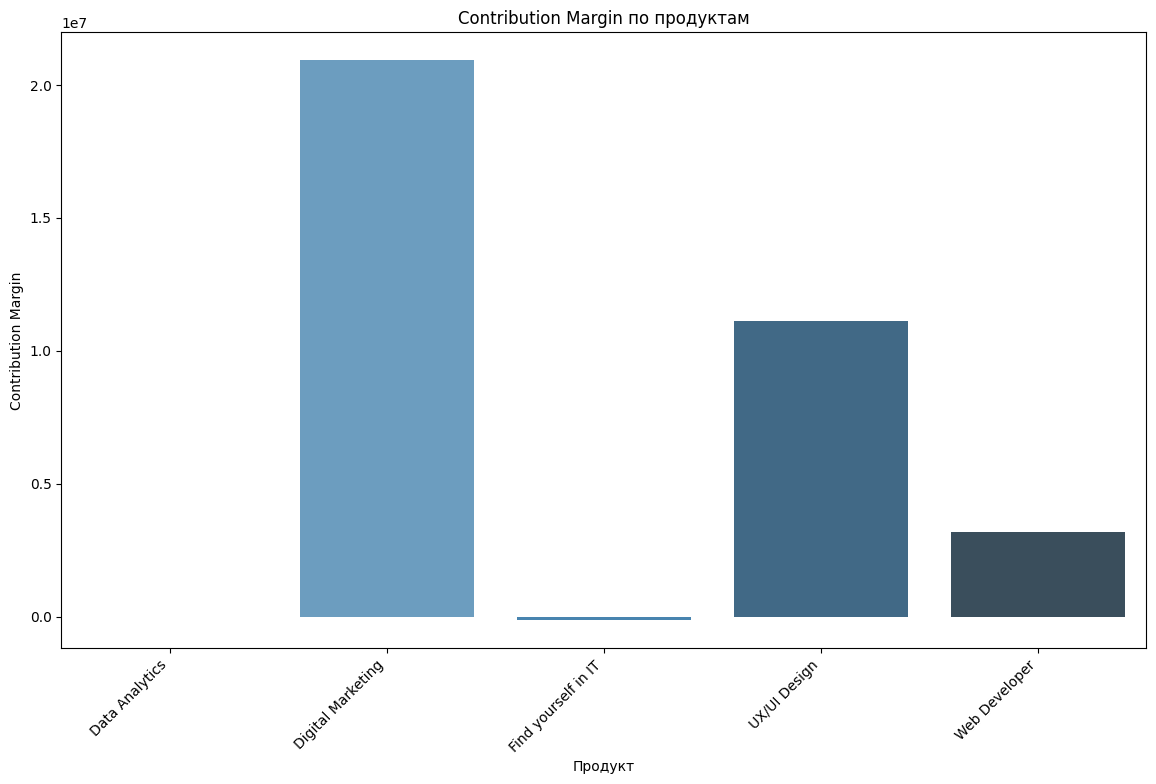

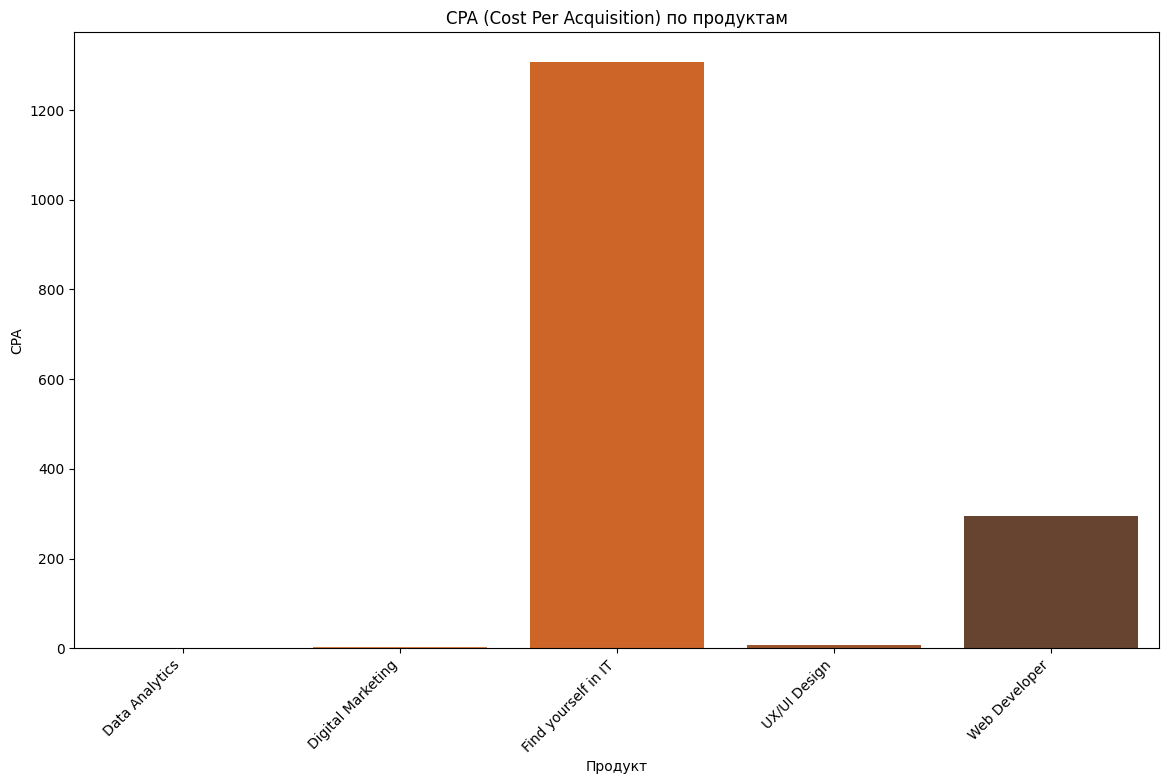

In [31]:
# Настройка размера графика
plt.figure(figsize=(14, 8))

# Построение столбчатой диаграммы для Contribution Margin
sns.barplot(x='product', y='Contribution Margin', data=product_deals_summary, hue='product', palette='Blues_d', legend=False)
plt.title('Contribution Margin по продуктам')
plt.xlabel('Продукт')
plt.ylabel('Contribution Margin')
plt.xticks(rotation=45, ha="right")
plt.show()

# Построение столбчатой диаграммы для CPA
plt.figure(figsize=(14, 8))
sns.barplot(x='product', y='CPA', data=product_deals_summary, hue='product', palette='Oranges_d', legend=False)
plt.title('CPA (Cost Per Acquisition) по продуктам')
plt.xlabel('Продукт')
plt.ylabel('CPA')
plt.xticks(rotation=45, ha="right")
plt.show()

### Анализ графиков:
**Contribution Margin по продуктам**:
Digital Marketing: Этот продукт имеет самый высокий показатель Contribution Margin (около 2.0e7). Это говорит о высокой марже после учета всех переменных затрат, что делает его наиболее прибыльным продуктом.
UX/UI Design: Следует за Digital Marketing и также показывает значительную маржу, однако ниже, чем у лидера.
Web Developer: Третий по прибыльности продукт, но значительно отстает от двух лидеров.
Find yourself in IT и Data Analytics: Эти продукты имеют крайне низкие показатели Contribution Margin. Возможно, это связано с низкими продажами или высокой стоимостью привлечения клиентов (CPA), что делает их менее прибыльными.

**CPA (Cost Per Acquisition) по продуктам**:
Find yourself in IT: Имеет чрезвычайно высокий показатель CPA, что может объяснять низкую прибыльность данного продукта. Высокие затраты на привлечение клиентов делают этот продукт нерентабельным.
Web Developer: Имеет умеренный CPA, что означает, что затраты на привлечение клиентов не так высоки, но, возможно, они всё ещё оказывают значительное влияние на рентабельность.
Digital Marketing и UX/UI Design: Оба продукта демонстрируют низкий CPA, что говорит о высокой эффективности маркетинговых расходов и способствуют высокой маржинальности этих продуктов.
Data Analytics: Показатели отсутствуют или крайне низкие, что может указывать на недостаток данных для анализа или на очень низкие маркетинговые расходы.

**Выводы**:
Digital Marketing и UX/UI Design – это самые прибыльные продукты с низким CPA и высоким Contribution Margin. Для этих продуктов стоит рассмотреть дальнейшее увеличение маркетинговых вложений для увеличения продаж.
Find yourself in IT демонстрирует очень высокий CPA, что делает его нерентабельным. Необходимо пересмотреть маркетинговую стратегию или стоимость продукта.
Web Developer имеет потенциал, но необходимо поработать над снижением CPA для увеличения маржи.
Data Analytics требует дальнейшего анализа, так как его текущие данные не позволяют сделать однозначные выводы. Возможно, стоит усилить маркетинг для увеличения продаж.

### Определение точек роста бизнеса на основе юнит-экономики предполагает выявление областей, в которых можно улучшить ключевые показатели, чтобы увеличить прибыльность и эффективность бизнеса. 
Давайте рассмотрим возможные точки роста на основании анализов, которые мы провели:

**1. Оптимизация затрат на привлечение клиентов (CPA)**:
Проблема: Высокий CPA для продуктов, таких как "Find yourself in IT", делает эти продукты нерентабельными.
Решение: Необходимо пересмотреть маркетинговую стратегию. Возможно, стоит сфокусироваться на более эффективных каналах привлечения клиентов или пересмотреть рекламные кампании, которые демонстрируют низкую конверсию, и перераспределить бюджет на более эффективные каналы.

**2. Увеличение маржи (Contribution Margin)**:
Проблема: Продукты с низкой маржинальностью, такие как "Find yourself in IT" и "Data Analytics", требуют улучшения.
Решение: Пересмотреть ценовую политику или попытаться снизить переменные затраты (например, путем оптимизации производства или логистики). Рассмотреть возможность увеличения цены на продукт при одновременном улучшении его ценности для клиента.

**3. Фокус на наиболее прибыльных продуктах**:
Вывод: Продукты, такие как "Digital Marketing" и "UX/UI Design", демонстрируют высокую маржинальность и низкий CPA.
Решение: Увеличить инвестиции в маркетинг для этих продуктов, чтобы привлечь больше клиентов. Возможно, стоит рассмотреть запуск новых продуктов, схожих по характеристикам с этими успешными продуктами.

**4. Повышение конверсии**:
Проблема: Некоторые рекламные кампании демонстрируют низкую конверсию от кликов к сделкам.
Решение: Пересмотреть контент и таргетинг рекламных кампаний. Возможно, требуется улучшить посадочные страницы или предложения, которые получают клиенты. Тестирование A/B и более детальный анализ воронки продаж помогут выявить слабые места и точки для улучшения.

**5. Перераспределение маркетингового бюджета**:
Вывод: Из анализа распределения затрат по кампаниям видно, что некоторые кампании имеют низкий возврат на инвестиции.
Решение: Оптимизировать бюджет, перераспределяя средства на более успешные кампании. Использовать данные о конверсии и CPA для принятия решений о том, какие кампании стоит масштабировать, а какие — прекратить.

**6. Развитие и поддержка успешных регионов**:
Вывод: Некоторые города и регионы показывают высокий уровень сделок и доходов.
Решение: Рассмотреть возможность увеличения присутствия и активности в этих регионах через целевые рекламные кампании или специальные предложения. В регионах с низкой активностью попробовать другие стратегии, возможно, индивидуальные подходы к рынку.

**7. Улучшение качества и предложения продуктов**:
Проблема: Низкий AOV (средний чек) в некоторых продуктах может свидетельствовать о том, что предложения недостаточно ценны для клиентов.
Решение: Рассмотреть возможность улучшения предложения продукта (например, добавление новых функций, улучшение сервиса), чтобы увеличить средний чек.

**8. Снижение оттока клиентов**:
Проблема: Если в анализе были выявлены проблемы с удержанием клиентов или высокой стоимостью повторного привлечения.
Решение: Разработать программу лояльности, улучшите обслуживание клиентов или предложите дополнительные продукты/услуги для существующих клиентов.

**9. Анализ новых продуктов и рынков**:
Вывод: Если продуктовые и географические сегменты показывают слабую эффективность, может иметь смысл разработать новые продукты или выйти на новые рынки.
Решение: Провести исследование рынка, чтобы выявить потенциально успешные новые направления.

**Заключение**:
Каждая из этих точек роста требует тестирования и анализа. Важно установить приоритеты по каждому направлению, чтобы не перегружать бизнес и команду. Использовать итерационный подход: улучшать показатели, отслеживать результаты, корректировать стратегию и масштабировать успешные практики.

***Основные цели, которые можно выделить, — это доход, прибыль, эффективность рекламных кампаний, и рентабельность***

**Дерево метрик** 
*1. Доход (Revenue)*
 - Общий доход (Total Revenue)
    - Сумма всех доходов от проданных продуктов.
 - Средний чек (AOV - Average Order Value)
    - Формула: AOV = Total Revenue / Total Orders
    - Показатель, который показывает средний доход с одного заказа.
 - Количество заказов (Total Orders)
    - Общее количество завершенных сделок (оплаченных).
 - Количество проданных единиц продукта (Total Units Sold)
    - Количество всех единиц проданных продуктов.

*2. Конверсия (Conversion Rate)*
 - Конверсия в оплату (Payment Conversion Rate)
    - Формула: Conversion Rate = (Payment Done Deals / Total Deals) * 100
    - Процент сделок, которые были завершены с оплатой.
 - Конверсия по рекламным кампаниям (Campaign Conversion Rate)
    - Конверсия на каждом этапе рекламной воронки:
      - CTR (Click Through Rate): Формула: (Total Clicks / Total Impressions) * 100
      - Conversion from Clicks to Deals: Формула: (Total Deals / Total Clicks) * 100
      - Conversion from Deals to Payments: Формула: (Payment Done Deals / Total Deals) * 100

*3. Маржинальность (Margin)*
 - Себестоимость проданных товаров (COGS - Cost of Goods Sold)
    - Общие затраты на производство товаров или услуг.
    - COGS на единицу (COGS per unit)
 - Contribution Margin
    - Формула: Contribution Margin = Total Revenue - COGS - CPA
    - Разница между выручкой и всеми переменными затратами на производство и маркетинг.
 - CPA (Cost Per Acquisition)
    - Формула: CPA = Total Spend / Payment Done Deals
    - Затраты на привлечение одного клиента.

*4. Эффективность рекламных кампаний*
 - Затраты на рекламу (Total Ad Spend)
    - Сумма всех затрат на рекламные кампании.
 - Эффективность кампаний
    - CPA: Стоимость привлечения одного клиента.
    - ROI (Return on Investment): Формула: (Revenue - Total Spend) / Total Spend
       - Рентабельность рекламных кампаний.

*5. Прибыль (Profit)*
 - Общая прибыль (Total Profit)
      - Формула: Total Revenue - Total Expenses (COGS + Total Ad Spend + Other Fixed Costs)
      - Показатель чистой прибыли компании после учета всех затрат.
 - Рентабельность (Profit Margin)
      - Формула: Profit Margin = (Total Profit / Total Revenue) * 100
      - Процент прибыли от общего дохода.

*Взаимосвязи между метриками*
 - Общий доход напрямую зависит от AOV и количества заказов.
 - Конверсия влияет на количество заказов, что, в свою очередь, увеличивает доход.
 - CPA и COGS уменьшают Contribution Margin, что снижает прибыль.
 - Эффективность рекламных кампаний (через CTR, конверсию и CPA) влияет на объем продаж и стоимость привлечения клиентов.
 - Рентабельность является конечной метрикой, которая показывает, насколько прибыльным является бизнес с учетом всех затрат и доходов.

**Выводы на основе дерева метрик**:
Увеличение AOV и конверсии может значительно повысить общий доход.
Оптимизация CPA и COGS улучшит Contribution Margin и, следовательно, прибыльность.
Анализ эффективности рекламных кампаний через такие метрики, как CTR и конверсии, поможет улучшить стратегию маркетинга и снизить затраты на привлечение клиентов.
Фокус на прибыльности: Выявление высокомаржинальных продуктов и кампаний для увеличения общей рентабельности бизнеса.

Чтобы понять, на какую метрику продукта будут воздействовать метрики дерева, необходимо определить ключевую метрику продукта, 
которая является наиболее важной для успеха бизнеса. Обычно это метрика, которая напрямую влияет на доход или прибыль, такие как доход 
на пользователя (ARPU), конверсия или рентабельность.

**Основная метрика продукта: Contribution Margin**
Contribution Margin (маржинальная прибыль) — это ключевая метрика, которая показывает, насколько продукт приносит доход, 
покрывающий затраты на его производство и маркетинг. В конечном итоге, это основная метрика, которая влияет на прибыль и рентабельность бизнеса.

**Влияние метрик дерева на Contribution Margin**:

**Доход (Revenue)**
AOV (Средний чек): Увеличение AOV напрямую увеличит общий доход, что положительно скажется на Contribution Margin.
Количество заказов (Total Orders): Увеличение количества заказов также увеличивает общий доход, что повышает Contribution Margin.

**Конверсия (Conversion Rate)**
Конверсия в оплату (Payment Conversion Rate): Увеличение этой метрики ведет к большему количеству успешных сделок, что повышает доход и, следовательно, Contribution Margin.
Конверсия по рекламным кампаниям: Повышение конверсии на каждом этапе рекламной воронки (CTR, конверсия кликов в сделки и конверсия сделок в оплаты) ведет к более эффективным затратам на маркетинг и улучшению общей прибыльности.

**Маржинальность (Margin)**
COGS (Себестоимость проданных товаров): Снижение COGS напрямую увеличивает маржинальную прибыль, так как уменьшает затраты на производство или закупку.
CPA (Стоимость привлечения клиента): Снижение CPA увеличивает Contribution Margin, так как уменьшает затраты на привлечение каждого клиента.

**Эффективность рекламных кампаний**
Затраты на рекламу (Total Ad Spend): Оптимизация рекламных затрат (например, снижение CPA) может увеличить Contribution Margin за счет уменьшения переменных затрат.


**Гипотезы для улучшения Contribution Margin**:

**Увеличение AOV**:
*Гипотеза*: Предложение дополнительных услуг или апсейл может увеличить средний чек (AOV) на заказ.
Тест: Введение пакетов премиум-услуг или скидок на второй товар.

**Улучшение конверсии на каждом этапе воронки**:
*Гипотеза*: Оптимизация посадочных страниц или улучшение рекламных объявлений может повысить CTR и конверсию кликов в сделки.
Тест: Проведение A/B тестирования различных вариантов посадочных страниц или креативов для рекламы.

**Снижение CPA**:
*Гипотеза*: Оптимизация каналов рекламы и таргетинга поможет снизить CPA.
Тест: Анализ эффективности различных рекламных каналов и перераспределение бюджета в пользу наиболее эффективных.

**Снижение COGS**:
*Гипотеза*: Переговоры с поставщиками или оптимизация производственных процессов могут снизить COGS.
Тест: Введение новых методов закупок или улучшение логистики.

**Увеличение количества заказов**:
*Гипотеза*: Улучшение пользовательского опыта и клиентского обслуживания приведет к росту количества повторных покупок.
Тест: Введение программ лояльности и работа с обратной связью клиентов для улучшения сервиса.

**Влияние на конечную метрику**:
Внедрение этих гипотез и улучшение связанных с ними метрик должно положительно сказаться на Contribution Margin. Например, если удастся увеличить AOV или снизить CPA, это увеличит прибыль с каждого заказа, что повысит общий Contribution Margin. Это, в свою очередь, ведет к росту общей рентабельности и эффективности бизнеса.

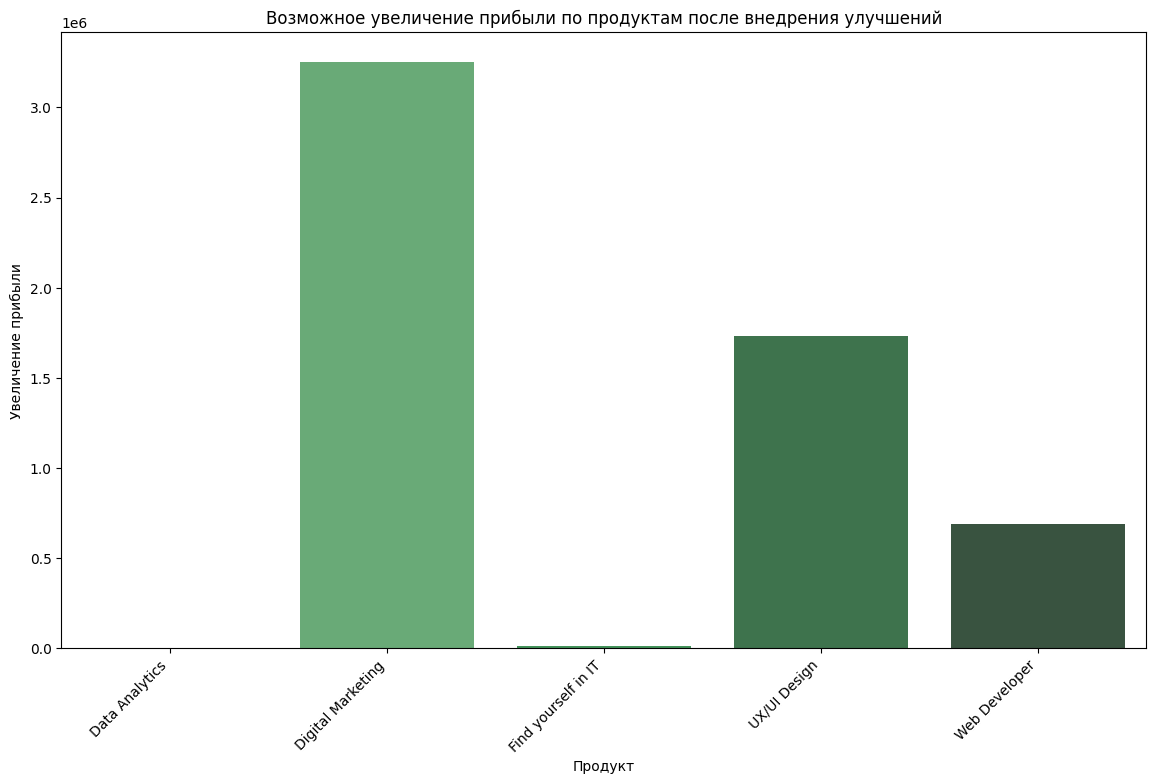

In [32]:
# Предположим улучшение для каждой метрики в процентах
improvement_aov = 0.1  # Увеличение AOV на 10%
improvement_conversion = 0.05  # Улучшение конверсии на 5%
reduction_cpa = 0.1  # Снижение CPA на 10%
reduction_cogs = 0.05  # Снижение COGS на 5%
increase_orders = 0.1  # Увеличение количества заказов на 10%

# Рассчитываем возможное увеличение прибыли для каждой гипотезы
product_deals_summary['Improved_AOV'] = product_deals_summary['AOV'] * (1 + improvement_aov)
product_deals_summary['Improved_Conversion_Rate'] = product_deals_summary['conversion_rate %'] * (1 + improvement_conversion)
product_deals_summary['Reduced_CPA'] = product_deals_summary['CPA'] * (1 - reduction_cpa)
product_deals_summary['Reduced_COGS'] = product_deals_summary['COGS_per_unit'] * (1 - reduction_cogs)
product_deals_summary['Increased_Orders'] = product_deals_summary['total_orders'] * (1 + increase_orders)

# Пересчет маржинальной прибыли
product_deals_summary['Improved_Contribution_Margin'] = (
    product_deals_summary['total_deals'] *
    (-product_deals_summary['Reduced_CPA'] + 
    product_deals_summary['Improved_Conversion_Rate'] / 100 * 
    (product_deals_summary['Improved_AOV'] - product_deals_summary['Reduced_COGS']) * 
    product_deals_summary['APC'])
)

# Рассчитываем разницу в прибыли до и после улучшений
product_deals_summary['Profit_Increase'] = product_deals_summary['Improved_Contribution_Margin'] - product_deals_summary['Contribution Margin']

# Визуализация результатов
plt.figure(figsize=(14, 8))
sns.barplot(x='product', y='Profit_Increase', data=product_deals_summary, palette='Greens_d', legend=False, hue='product')
plt.title('Возможное увеличение прибыли по продуктам после внедрения улучшений')
plt.xlabel('Продукт')
plt.ylabel('Увеличение прибыли')
plt.xticks(rotation=45, ha="right")
plt.show()

### На графике представлено возможное увеличение прибыли по продуктам после внедрения предложенных улучшений:

**Digital Marketing**:

Этот продукт имеет наибольший потенциал для увеличения прибыли. Это связано с его высоким AOV и количеством сделок. 
Улучшения в конверсии и снижении затрат на привлечение (CPA) могут значительно увеличить маржинальную прибыль.

**UX/UI Design**:

Этот продукт также демонстрирует значительный потенциал роста прибыли, но он значительно меньше, чем у Digital Marketing. 
Это может свидетельствовать о возможности улучшения эффективности текущих стратегий продаж и маркетинга.

**Web Developer**:

Продукт показывает умеренный потенциал увеличения прибыли. Несмотря на относительно высокую конверсию, улучшения в AOV и 
снижение CPA могут оказать существенное влияние на прибыль.

**Find yourself in IT**:

Продукт имеет небольшой потенциал роста прибыли, что может указывать на низкий текущий объем продаж или высокие затраты на привлечение.

**Data Analytics**:

Этот продукт не показывает значительного роста прибыли, возможно, из-за низкого текущего объема продаж или недостаточного 
уровня улучшений в ключевых метриках.

**Заключение**:
Основные усилия следует направить на продукты с наибольшим потенциалом увеличения прибыли, такие как Digital Marketing и 
UX/UI Design, поскольку улучшения в этих областях могут принести наибольшую отдачу для бизнеса. Улучшения в других продуктах могут 
потребовать более точечной настройки стратегий для достижения значимого эффекта.

### Для дальнейшего анализа и поиска точек роста, можно рассмотреть следующие подходы:

**1. Анализ воронки продаж**:
Выявление этапов с наибольшим оттоком: Проверить, на каком этапе воронки (от показов до кликов, от кликов до сделок и от сделок до оплаты) 
происходит наибольший отток. Это позволит понять, где сосредоточить усилия для повышения конверсии.
Оптимизация этапов воронки: После выявления слабых мест, можно рассмотреть конкретные улучшения, такие как изменение содержания рекламы, 
улучшение пользовательского опыта на сайте или повышение качества работы отдела продаж.

**2. Сегментация клиентов**:
Анализ по демографическим данным: Разделить клиентов на сегменты по возрасту, полу, географии и проанализируйте, какие группы приносят 
наибольшую прибыль. Это поможет оптимизировать маркетинговые кампании и сосредоточить усилия на наиболее прибыльных сегментах.
Анализ поведения клиентов: Изучить поведение клиентов, такие как средний срок между первым кликом и покупкой, количество повторных покупок и 
средний чек для разных сегментов. Это поможет выявить сегменты с высоким потенциалом для роста.
    
**3. Оптимизация расходов на рекламу (ROAS)**:
Анализ ROAS (возврат на рекламные расходы) по кампаниям: Определить рекламные кампании с низким ROAS и подумать о перераспределении бюджетов в пользу 
более эффективных кампаний.
Тестирование различных рекламных каналов: Провести A/B тестирование различных рекламных каналов и креативов, чтобы определить, какие из них 
наиболее эффективно привлекают платежеспособных клиентов.

**4. Анализ конкурентной среды**:
Бенчмаркинг: Сравнить ключевые метрики с показателями конкурентов, если такие данные доступны. Это поможет понять, где мы отстаем, а 
где у нас есть преимущества.
SWOT-анализ: Провести анализ сильных и слабых сторон нашего бизнеса, возможностей на рынке и угроз. Это поможет сосредоточить усилия на 
использовании возможностей и минимизации угроз.

**5. Улучшение продукта**:
Анализ отзывов клиентов: Собирать и проанализировать отзывы клиентов, чтобы понять, какие аспекты продукта или обслуживания можно улучшить.
Разработка новых предложений: Если обнаружены запросы, которые не удовлетворены текущим ассортиментом, можно рассмотреть возможность разработки 
новых продуктов или услуг.
    
**6. Улучшение клиентского сервиса**:
Скорость и качество обработки заказов: Ускорение процесса обработки заказов и улучшение качества сервиса может повысить удовлетворенность 
клиентов и, следовательно, их лояльность и готовность к повторным покупкам.
Персонализация: Внедрение персонализированных предложений и рекомендаций может увеличить конверсию и средний чек.

**7. Анализ ценовой стратегии**:
Эластичность цен: Определите, насколько чувствительны клиенты к изменениям цен, и оптимизировать ценовую политику для увеличения маржи или 
объема продаж.
Конкурентное ценообразование: Сравнить наши цены с ценами конкурентов и определите, насколько мы конкурентоспособны на рынке.

**8. Использование данных для прогнозирования**:
Прогнозирование спроса: Использовать исторические данные для прогнозирования спроса на продукты в будущем, что поможет оптимизировать 
предложение.
Предсказательная аналитика: Использовать методы машинного обучения для предсказания вероятности повторных покупок или ухода клиентов (Churn).

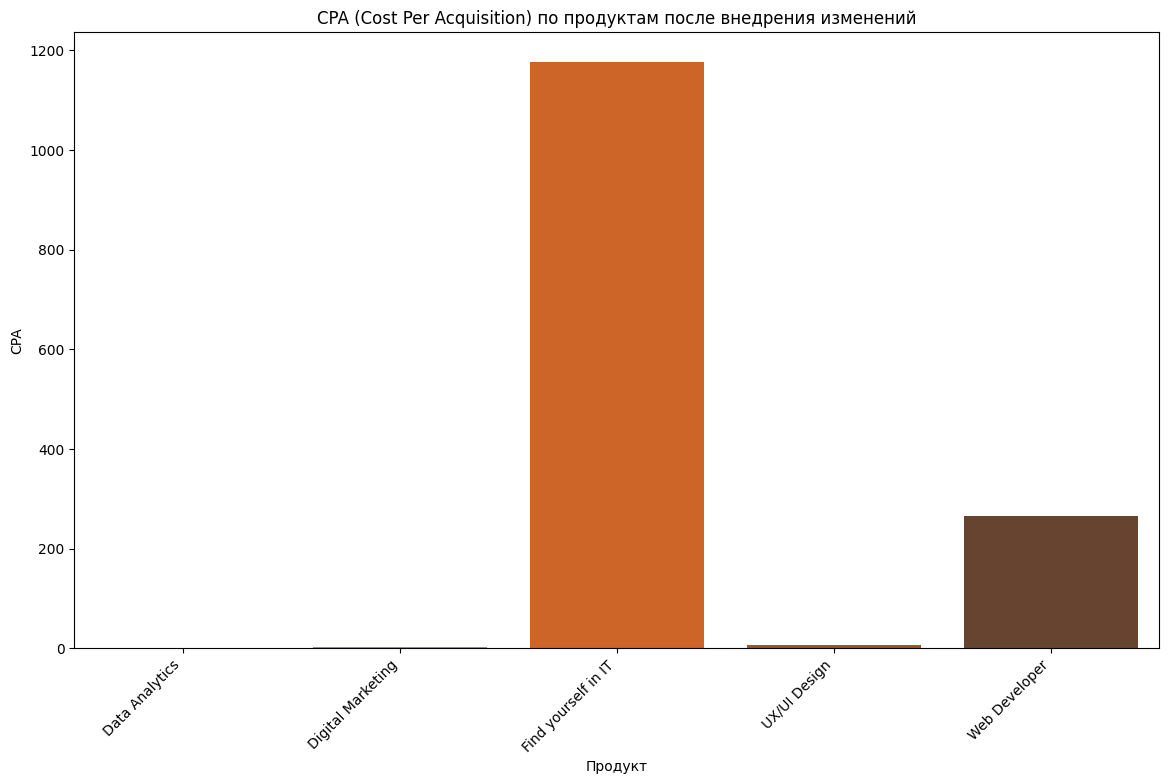

In [38]:
# Построение столбчатой диаграммы для CPA
plt.figure(figsize=(14, 8))
sns.barplot(x='product', y='Reduced_CPA', data=product_deals_summary, hue='product', palette='Oranges_d', legend=False)
plt.title('CPA (Cost Per Acquisition) по продуктам после внедрения изменений')
plt.xlabel('Продукт')
plt.ylabel('CPA')
plt.xticks(rotation=45, ha="right")
plt.show()

,city,total_deals,total_revenue,avg_order_value
0,Aachen,78,769000.0,9858.974359
1,Aalen,9,87000.0,9666.666667
2,Abensberg,10,73500.0,7350.000000
3,Achberg,12,117000.0,9750.000000
4,Adelebsen,4,38000.0,9500.000000
...,...,...,...,...
866,Zwingenberg,10,104500.0,10450.000000
867,Öhringen,8,88000.0,11000.000000
868,Übelbach,12,119000.0,9916.666667
869,Überlingen,11,96500.0,8772.727273


,city,total_deals,total_revenue,avg_order_value,revenue_segment,deals_segment
0,Aachen,78,769000.0,9858.974359,Very High,Very High
1,Aalen,9,87000.0,9666.666667,Medium,Low
2,Abensberg,10,73500.0,7350.000000,Low,Medium
3,Achberg,12,117000.0,9750.000000,High,High
4,Adelebsen,4,38000.0,9500.000000,Low,Low
...,...,...,...,...,...,...
866,Zwingenberg,10,104500.0,10450.000000,Medium,Medium
867,Öhringen,8,88000.0,11000.000000,Medium,Low
868,Übelbach,12,119000.0,9916.666667,High,High
869,Überlingen,11,96500.0,8772.727273,Medium,Medium


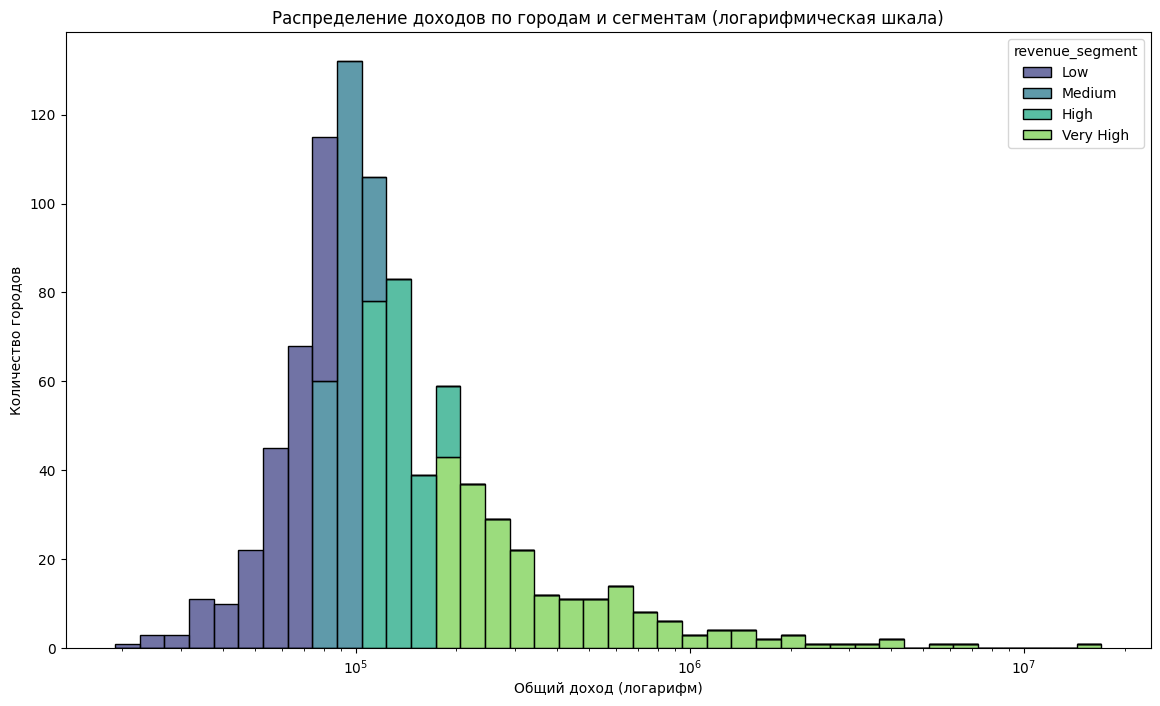

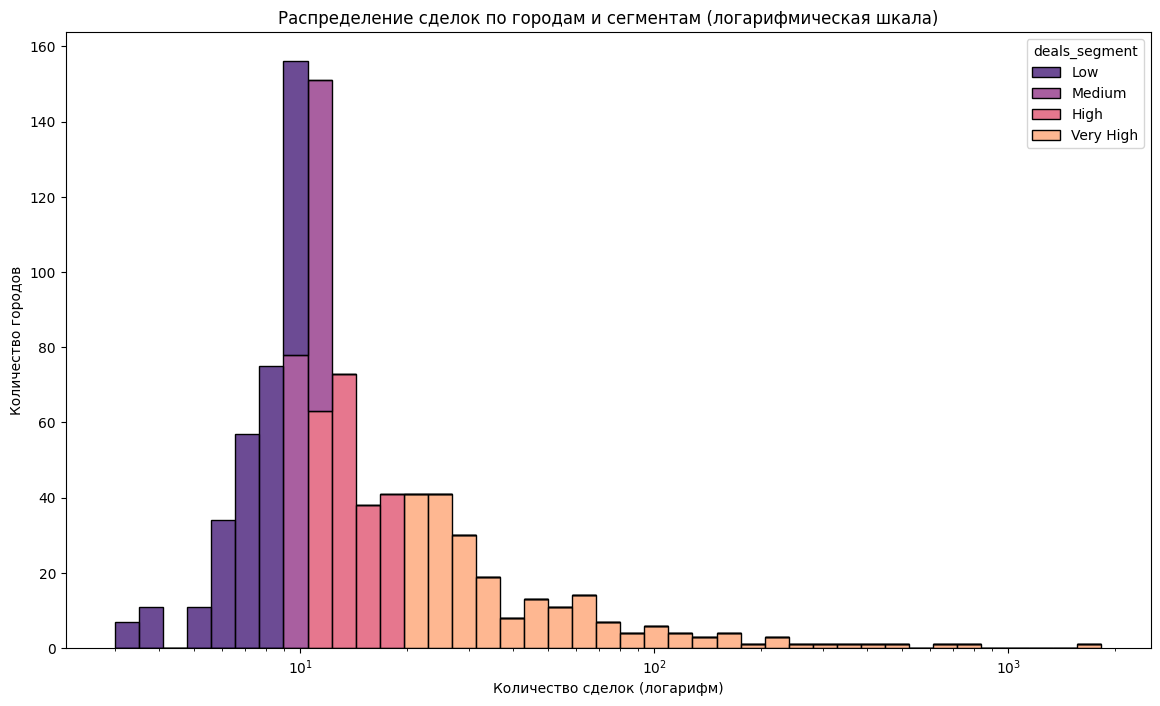

,city,total_deals,total_revenue,avg_order_value,revenue_segment,deals_segment
88,Berlin,1833,17041900.0,9297.272231,Very High,Very High
522,München,739,6836900.0,9251.556157,Very High,Very High
289,Hamburg,619,5764400.0,9312.439418,Very High,Very High
430,Leipzig,463,4201000.0,9073.434125,Very High,Very High
572,Nürnberg,422,3980401.0,9432.229858,Very High,Very High
177,Düsseldorf,359,3485001.0,9707.523677,Very High,Very High
169,Dresden,291,2661700.0,9146.735395,Very High,Very High
222,Frankfurt,279,2599500.0,9317.204301,Very High,Very High
168,Dortmund,237,2168000.0,9147.679325,Very High,Very High
406,Köln,233,2165700.0,9294.849785,Very High,Very High


,city,total_deals,total_revenue,avg_order_value,revenue_segment,deals_segment
88,Berlin,1833,17041900.0,9297.272231,Very High,Very High
522,München,739,6836900.0,9251.556157,Very High,Very High
289,Hamburg,619,5764400.0,9312.439418,Very High,Very High
430,Leipzig,463,4201000.0,9073.434125,Very High,Very High
572,Nürnberg,422,3980401.0,9432.229858,Very High,Very High
177,Düsseldorf,359,3485001.0,9707.523677,Very High,Very High
169,Dresden,291,2661700.0,9146.735395,Very High,Very High
222,Frankfurt,279,2599500.0,9317.204301,Very High,Very High
168,Dortmund,237,2168000.0,9147.679325,Very High,Very High
406,Köln,233,2165700.0,9294.849785,Very High,Very High


In [34]:
#проведем сегментный анализ клиентов на основе городов:

#1. Группировка данных по городам: Начнем с группировки клиентов по городам, чтобы определить, в каких городах сосредоточено наибольшее количество клиентов и доход от них. Это позволит выявить города с наибольшим и наименьшим потенциалом.
# Группировка по городам и расчет ключевых метрик
city_analysis = deals_df.groupby('city').agg(
    total_deals=('id', 'count'),
    total_revenue=('offer total amount', 'sum'),
    avg_order_value=('offer total amount', 'mean')
).reset_index()

# Вывод результатов
display(city_analysis)

#2. Сегментация по доходу и количеству сделок: делим города на сегменты в зависимости от общего дохода и количества сделок. Это позволит выявить города, которые являются ключевыми для бизнеса, и те, которые требуют дополнительных усилий.

# Сегментирование городов по доходу
city_analysis['revenue_segment'] = pd.qcut(city_analysis['total_revenue'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Сегментирование городов по количеству сделок
city_analysis['deals_segment'] = pd.qcut(city_analysis['total_deals'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Вывод результатов
display(city_analysis)

#3. Построение графиков для анализа сегментов: 

# Гистограмма для распределения доходов по сегментам
plt.figure(figsize=(14, 8))
sns.histplot(data=city_analysis, x='total_revenue', hue='revenue_segment', multiple='stack', palette='viridis', log_scale=True)
plt.title('Распределение доходов по городам и сегментам (логарифмическая шкала)')
plt.xlabel('Общий доход (логарифм)')
plt.ylabel('Количество городов')
plt.show()

# Гистограмма для распределения сделок по сегментам
plt.figure(figsize=(14, 8))
sns.histplot(data=city_analysis, x='total_deals', hue='deals_segment', multiple='stack', palette='magma', log_scale=True)
plt.title('Распределение сделок по городам и сегментам (логарифмическая шкала)')
plt.xlabel('Количество сделок (логарифм)')
plt.ylabel('Количество городов')
plt.show()

#4. Анализ ключевых городов: выделяем топ-10 городов по каждому сегменту и проведим детальный анализ их показателей.

# Топ-10 городов по доходу
top_cities_by_revenue = city_analysis.sort_values(by='total_revenue', ascending=False).head(10)
display(top_cities_by_revenue)

# Топ-10 городов по количеству сделок
top_cities_by_deals = city_analysis.sort_values(by='total_deals', ascending=False).head(10)
display(top_cities_by_deals)



### На данном графике представлено распределение доходов по городам и сегментам с использованием логарифмической шкалы. 
График показывает, что большинство городов сконцентрировано в сегментах с низким и средним доходом, что характерно для многих рынков, где основная масса продаж приходится на менее крупные регионы.

**Низкий и Средний сегменты дохода**: Наибольшее количество городов находится в этих сегментах, что отражает стандартное распределение доходов, где малые и средние города составляют основную долю базы клиентов.

**Высокий и Очень высокий сегменты дохода**: Меньшее количество городов в этих сегментах указывает на то, что высокие доходы концентрируются в ограниченном числе крупных городов.

<Figure size 1400x800 with 0 Axes>

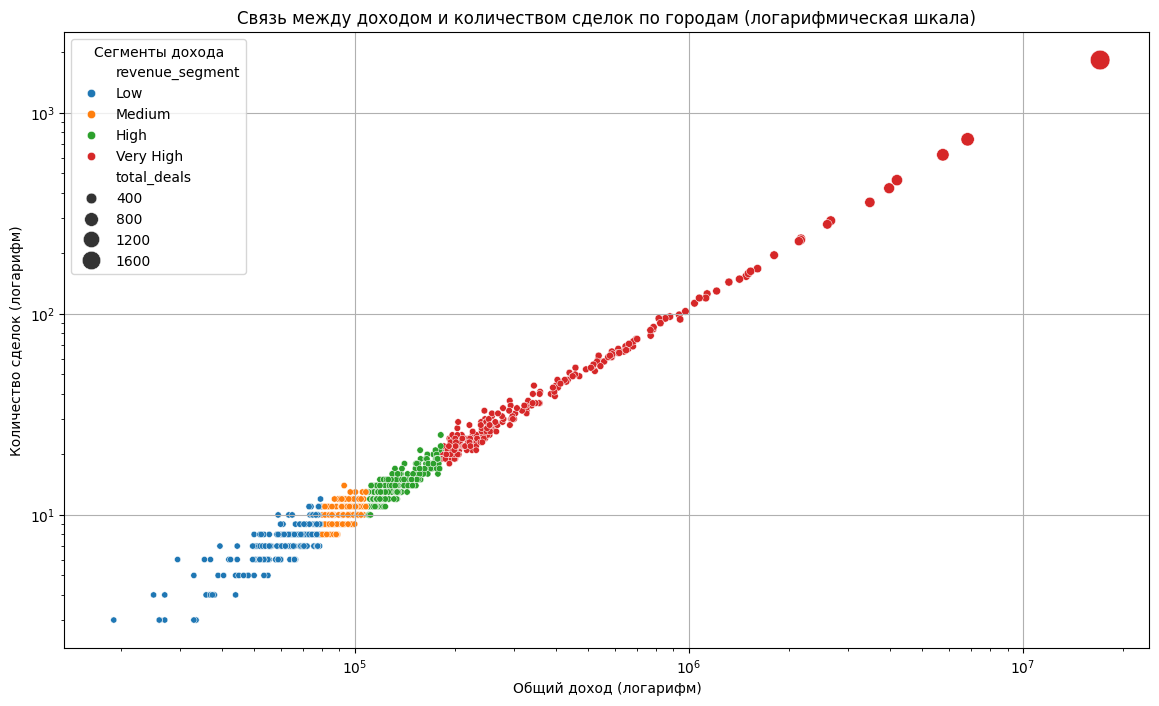

In [35]:
plt.figure(figsize=(14, 8))
plt.figure(figsize=(14, 8))

# Построение диаграммы разброса
sns.scatterplot(x='total_revenue', y='total_deals', data=city_analysis, hue='revenue_segment', size='total_deals', sizes=(20, 200))

# Установка логарифмической шкалы для осей
plt.xscale('log')
plt.yscale('log')

# Настройки оформления графика
plt.title('Связь между доходом и количеством сделок по городам (логарифмическая шкала)')
plt.xlabel('Общий доход (логарифм)')
plt.ylabel('Количество сделок (логарифм)')
plt.legend(title='Сегменты дохода')
plt.grid(True)
plt.show()

### На графике представлена связь между общим доходом и количеством сделок по городам, с использованием логарифмической шкалы по обеим осям.

**Ключевые наблюдения**:
Прямая зависимость: График показывает чёткую прямую зависимость между общим доходом и количеством сделок, что подтверждается линейной регрессией в логарифмическом масштабе. Это означает, что увеличение количества сделок напрямую связано с увеличением дохода.

**Сегментация городов**:

Сегменты с низким и средним доходом (Low и Medium): В этих сегментах расположено множество городов, однако они генерируют относительно небольшой доход, и число сделок у них также относительно невелико.

Сегменты с высоким и очень высоким доходом (High и Very High): Небольшое количество городов в этих сегментах генерирует значительно больший доход, с высоким количеством сделок. Эти города представлены красными точками и находятся в правой части графика.

Размер маркеров: Размер маркеров (точек) на графике варьируется в зависимости от количества сделок, что позволяет визуально выделить города с наибольшим числом сделок. Чем больше маркер, тем больше сделок в данном городе.

**Вывод**:
Большая часть дохода и сделок сосредоточена в нескольких городах с высоким и очень высоким уровнем дохода, что подтверждает необходимость фокусировки маркетинговых усилий на этих регионах. Однако существуют и города с потенциалом для роста, особенно в сегментах с низким и средним доходом. В этих сегментах можно рассматривать возможности для увеличения количества сделок и, следовательно, дохода.

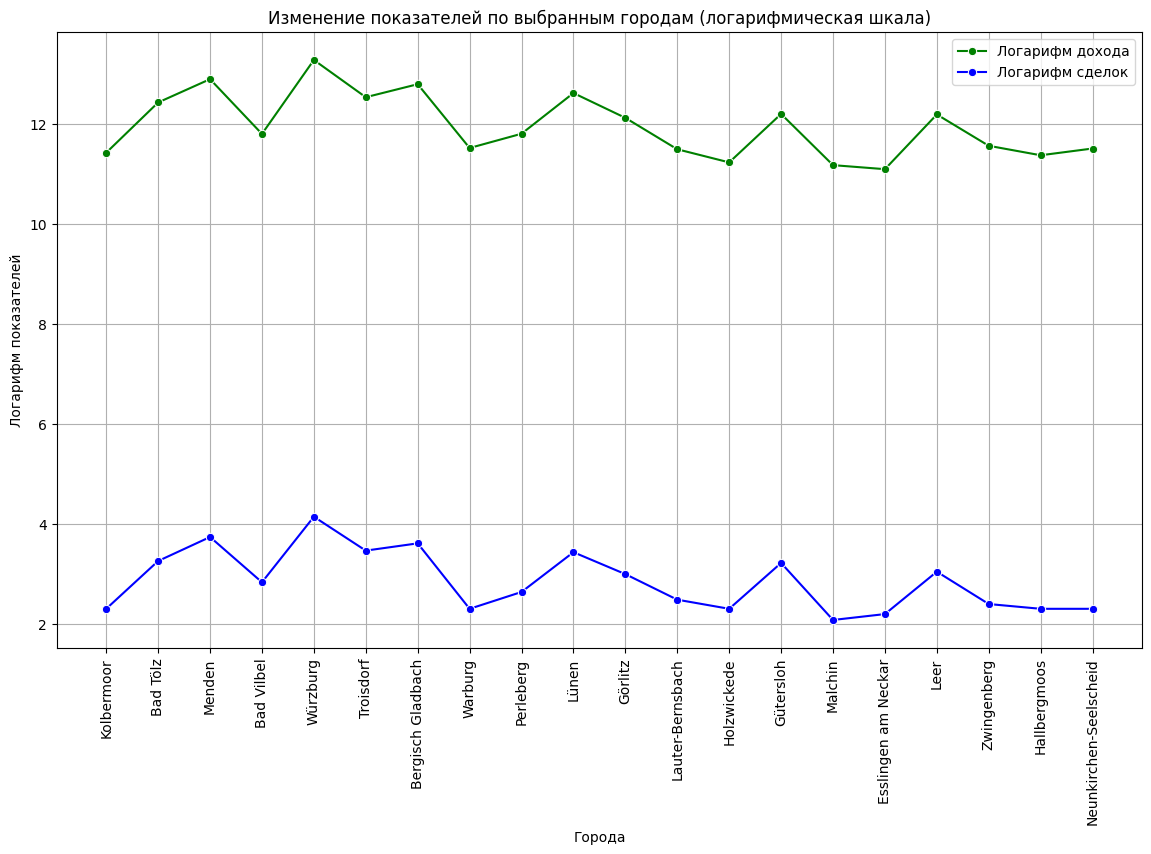

In [36]:
# Случайным образом выбираем 20 городов
sampled_cities = city_analysis.sample(n=20, random_state=42)

# Построение графика
plt.figure(figsize=(14, 8))
sns.lineplot(x='city', y=np.log1p(sampled_cities['total_revenue']), data=sampled_cities, label='Логарифм дохода', marker='o', color='green')
sns.lineplot(x='city', y=np.log1p(sampled_cities['total_deals']), data=sampled_cities, label='Логарифм сделок', marker='o', color='blue')
plt.title('Изменение показателей по выбранным городам (логарифмическая шкала)')
plt.xlabel('Города')
plt.ylabel('Логарифм показателей')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

### На представленном графике показаны логарифмические значения дохода и количества сделок по 20 случайно выбранным городам.

**Логарифм дохода (зеленая линия)**:

Видно, что доходы сильно варьируются между городами, несмотря на использование логарифмической шкалы.
Большинство городов на графике имеют относительно высокий логарифм дохода, что может указывать на более успешные или крупные сделки в этих местах.

**Логарифм сделок (синяя линия)**:

Количество сделок также варьируется, но в среднем имеет меньший разброс по сравнению с доходом.
Некоторым городам с высоким логарифмом дохода соответствуют относительно низкие значения логарифма сделок, что может указывать на высокую стоимость отдельных сделок в этих местах.

**Выводы**:
Города с более высоким доходом не всегда имеют высокое количество сделок, что говорит о том, что в этих городах могут проводиться крупные сделки.
Сравнение логарифмов дохода и количества сделок помогает выявить города с высоким потенциалом для улучшения продаж (например, те, где много сделок, но относительно низкий доход).

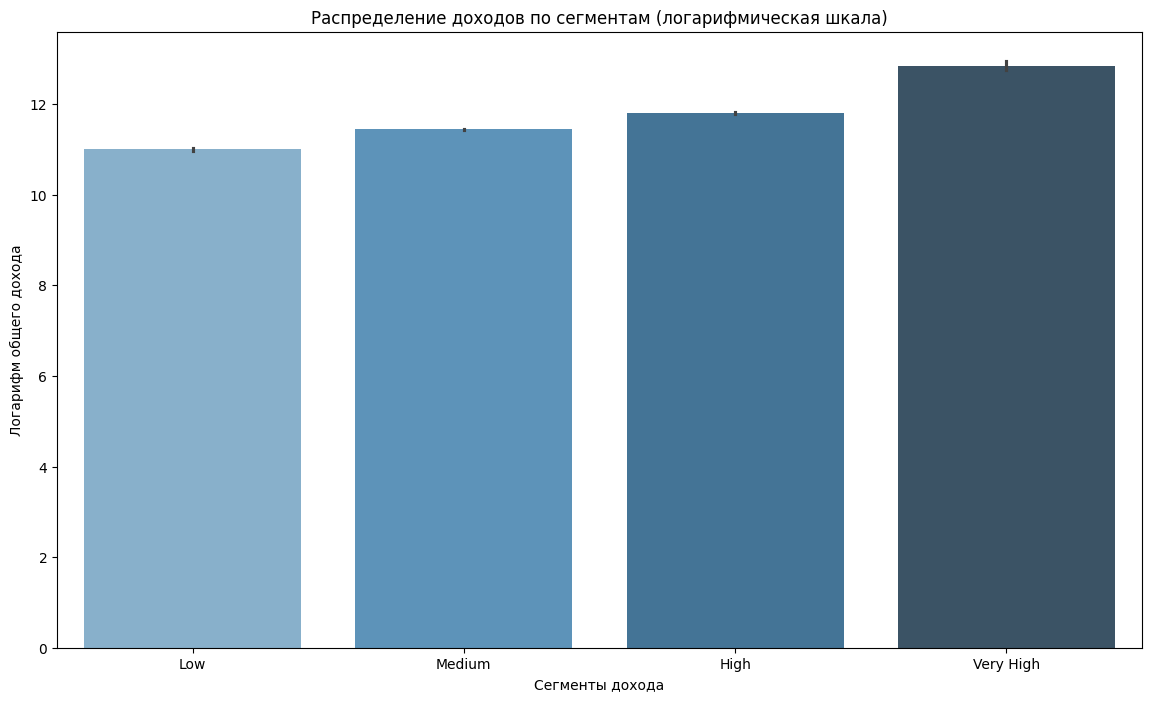

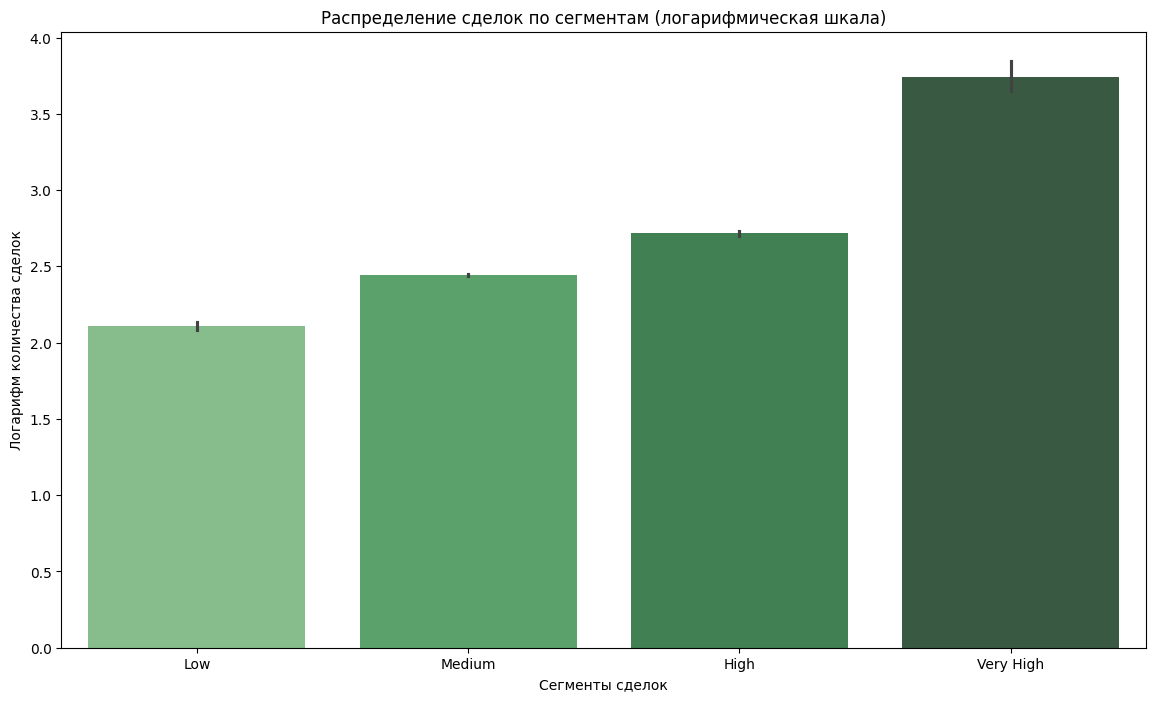

In [37]:
plt.figure(figsize=(14, 8))
sns.barplot(x='revenue_segment', y=np.log1p(city_analysis['total_revenue']), data=city_analysis, palette='Blues_d', legend=False, hue='revenue_segment')
plt.title('Распределение доходов по сегментам (логарифмическая шкала)')
plt.xlabel('Сегменты дохода')
plt.ylabel('Логарифм общего дохода')
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='deals_segment', y=np.log1p(city_analysis['total_deals']), data=city_analysis, palette='Greens_d', legend=False, hue='deals_segment')
plt.title('Распределение сделок по сегментам (логарифмическая шкала)')
plt.xlabel('Сегменты сделок')
plt.ylabel('Логарифм количества сделок')
plt.show()

### На графике представлено распределение доходов по сегментам на логарифмической шкале.

**Сегментация доходов**:

Доходы разделены на четыре категории: Low (низкий), Medium (средний), High (высокий) и Very High (очень высокий).
График показывает, что, как и ожидалось, логарифм доходов увеличивается с переходом от низкого к очень высокому сегменту доходов.

**Разброс значений**:

Для каждого сегмента разброс доходов относительно небольшой, что говорит о стабильности доходов в пределах каждой категории.
Самые высокие доходы соответствуют сегменту "Very High", с логарифмическим значением около 12, что значительно выше других категорий.

**Преемственность**:

Видно постепенное увеличение логарифмического значения доходов от "Low" к "Very High", что свидетельствует о логичной иерархии сегментов дохода.

**Выводы**:
Логарифмическая шкала помогла нивелировать резкие перепады в доходах между сегментами, делая график более информативным и наглядным.
Сегмент "Very High" имеет наиболее значительные доходы, что можно использовать для определения целевой аудитории при разработке маркетинговых стратегий.
Анализ сегментации доходов позволяет лучше понять распределение клиентов по доходности и выявить потенциальные области для повышения эффективности.

### На графике показано распределение сделок по сегментам на логарифмической шкале.

**Сегментация сделок**:

Сделки разделены на четыре категории: Low (низкий), Medium (средний), High (высокий) и Very High (очень высокий).
График показывает, что логарифм количества сделок увеличивается с переходом от низкого к очень высокому сегменту сделок.

**Разброс значений**:

Для каждого сегмента разброс количества сделок относительно небольшой, что говорит о стабильности в пределах каждой категории.
Самый высокий логарифм количества сделок наблюдается в сегменте "Very High", что указывает на более значительное количество сделок в этом сегменте.

**Преемственность**:

Логарифмическое значение количества сделок плавно увеличивается от "Low" к "Very High", что демонстрирует последовательную зависимость между сегментами.

**Выводы**:
Логарифмическая шкала помогает визуализировать различия между сегментами более плавно, устраняя резкие перепады.
Сегмент "Very High" лидирует по количеству сделок, что может свидетельствовать о более активных и результативных маркетинговых стратегиях для клиентов этого сегмента.
Данный анализ позволяет понять распределение клиентов по количеству сделок и помогает выделить наиболее значимые сегменты для дальнейшей работы.

### Обобщенный вывод по продуктовой аналитике:

Продуктовая аналитика проекта показала, что продукты "Digital Marketing" и "UX/UI Design" являются наиболее рентабельными с высоким 
соотношением LTV/CAC, что указывает на успешные маркетинговые стратегии и эффективное использование ресурсов. Продукт "Web Developer" 
также демонстрирует потенциал, но требует оптимизации расходов или увеличения объема продаж для повышения рентабельности. 
В то же время продукт "Find yourself in IT" показал низкую эффективность, что может свидетельствовать о необходимости пересмотра маркетинговой 
стратегии и перераспределения бюджетов. Также был выявлен высокий потенциал для улучшения эффективности рекламных кампаний, 
особенно в части повышения CTR и конверсии от кликов к сделкам. В рамках проекта предложены рекомендации по оптимизации затрат, 
перераспределению ресурсов на более успешные кампании и улучшению стратегий для менее эффективных продуктов. Дальнейшие шаги включают 
фокус на развитии успешных продуктов и переработку маркетинговых стратегий для слабых направлений с целью увеличения общей рентабельности бизнеса.